In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
from tensorflow.keras.applications import ResNet50,EfficientNetB0, MobileNet,InceptionV3         
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torchvision.models as models
from sklearn.metrics import classification_report
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim

2025-11-01 10:21:41.553805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761992501.820005      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761992501.885532      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [56]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 375 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Akbar', 'Dilkash', 'urooj']

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
len (val_ds)

1

In [9]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=15,          
    restore_best_weights=True  
)


# ResNet50

In [11]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [15]:
def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    top_model = Dropout(0.6)(top_model) 
    top_model = Dense(n_classes, activation='softmax')(top_model)
    return top_model

In [13]:
FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

In [15]:
resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [16]:
history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )

Epoch 1/50


I0000 00:00:1761833043.284460     101 service.cc:148] XLA service 0x7a9f28004060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761833043.285143     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761833044.792197     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3090 - loss: 15.7269 

I0000 00:00:1761833048.995092     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4914 - loss: 14.2156 - val_accuracy: 0.9375 - val_loss: 9.5494
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7579 - loss: 9.1399 - val_accuracy: 0.9062 - val_loss: 6.6048
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8270 - loss: 6.2871 - val_accuracy: 0.9062 - val_loss: 4.7488
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8399 - loss: 4.5959 - val_accuracy: 0.9375 - val_loss: 3.6154
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8277 - loss: 3.5863 - val_accuracy: 0.9375 - val_loss: 2.9300
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8238 - loss: 2.9939 - val_accuracy: 0.9062 - val_loss: 2.5228
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9169 - loss: 2.4225 - val_accuracy: 0.9375 - val_loss: 2.0912
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8769 - loss: 2.1237 - val_accuracy: 0.9375 - val_loss: 1.

**Classification Report on test Dataset**

In [17]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


Accuracy:  0.8750
Precision: 0.9028
Recall:    0.8750
F1-Score:  0.8650

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.78      1.00      0.88        14
       urooj       1.00      0.56      0.71         9

    accuracy                           0.88        32
   macro avg       0.93      0.85      0.86        32
weighted avg       0.90      0.88      0.86        32



**Trainning and Validation Accuracy**

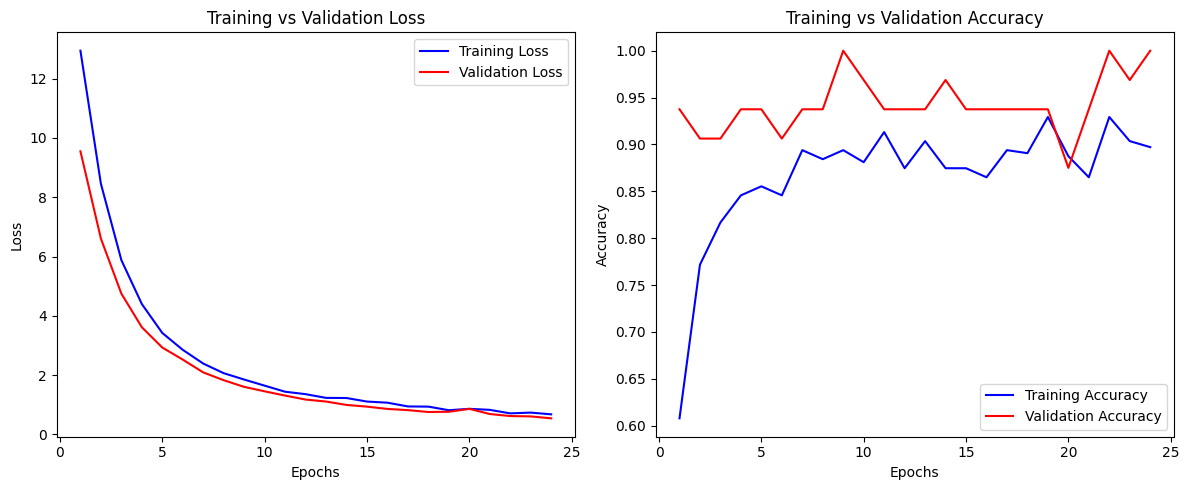

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Confusion Matrix**

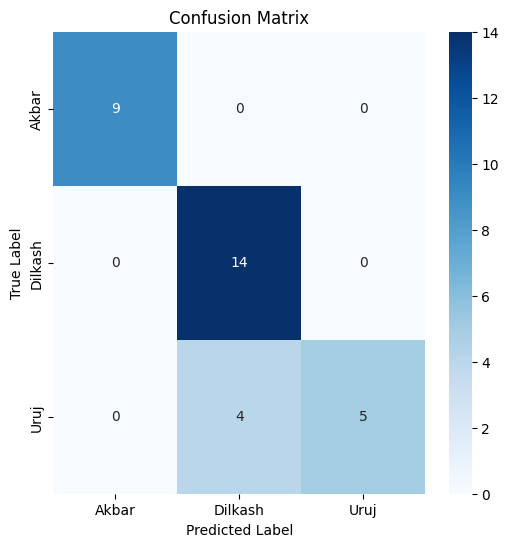

In [21]:
cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Effecient Net

In [22]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)

In [24]:
efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [25]:
history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5452 - loss: 11.6066 - val_accuracy: 0.8438 - val_loss: 8.5326
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7194 - loss: 8.0562 - val_accuracy: 0.9375 - val_loss: 5.9527
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7638 - loss: 5.5682 - val_accuracy: 0.8438 - val_loss: 4.1330
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7775 - loss: 3.9211 - val_accuracy: 0.7812 - val_loss: 3.0707
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8014 - loss: 2.8621 - val_accuracy: 0.7812 - val_loss: 2.3125
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8027 - loss: 2.1869 - val_accuracy: 0.9062 - val_loss: 1.7039
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7977 - loss: 1.8444 - val_accuracy: 0.9375 - val_loss: 1.4106
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8718 - loss: 1.3930 - val_accuracy: 0.9688 - v

In [26]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = efficientnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


Accuracy:  0.8438
Precision: 0.8665
Recall:    0.8438
F1-Score:  0.8455

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.91      0.71      0.80        14
        Uruj       0.67      0.89      0.76         9

    accuracy                           0.84        32
   macro avg       0.86      0.87      0.85        32
weighted avg       0.87      0.84      0.85        32



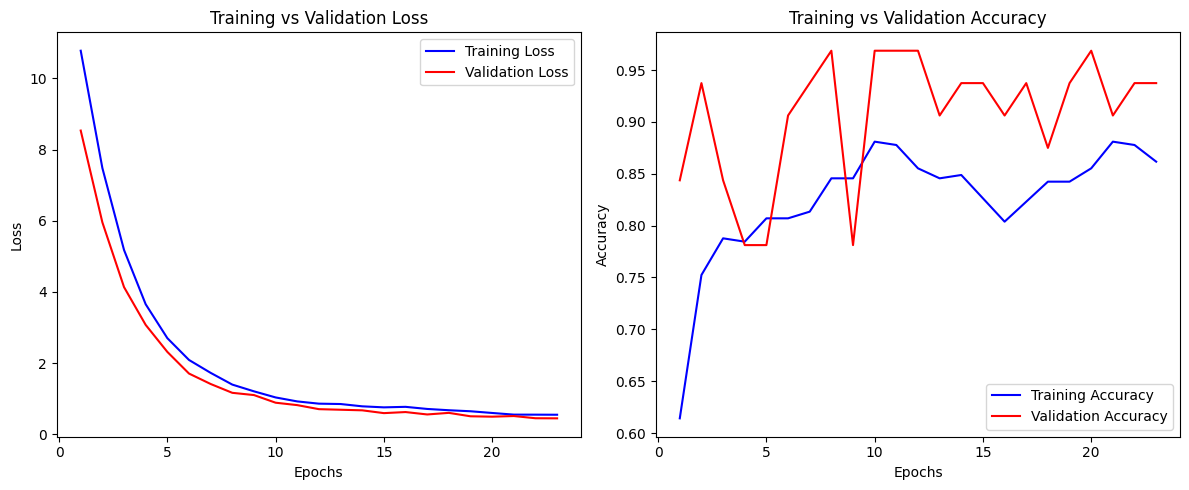

In [27]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

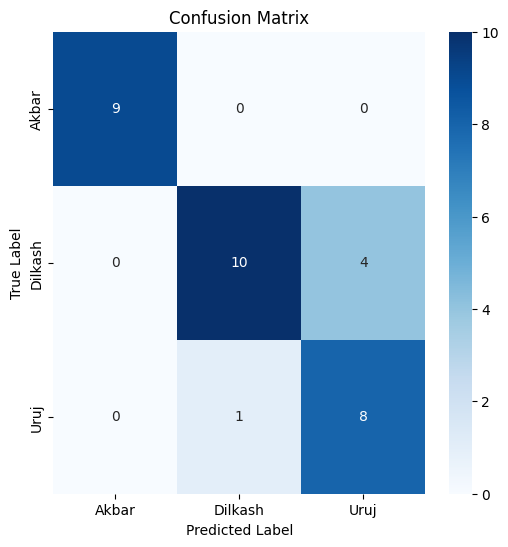

In [28]:
cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# MobileNet

In [29]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [30]:
FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

In [31]:
mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [32]:
history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 577ms/step - accuracy: 0.3685 - loss: 11.3608 - val_accuracy: 0.6562 - val_loss: 7.6362
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5999 - loss: 7.3402 - val_accuracy: 0.6562 - val_loss: 5.5266
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6430 - loss: 5.1679 - val_accuracy: 0.5938 - val_loss: 4.0965
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7126 - loss: 3.7798 - val_accuracy: 0.6875 - val_loss: 2.9966
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7723 - loss: 2.9143 - val_accuracy: 0.8438 - val_loss: 2.4423
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7793 - loss: 2.4180 - val_accuracy: 0.9062 - val_loss: 2.0769
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8288 - loss: 2.0496 - val_accuracy: 0.6875 - val_loss: 2.0436
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7636 - loss: 1.9844 - val_accuracy: 0.8438 

In [33]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


Accuracy:  0.8438
Precision: 0.8849
Recall:    0.8438
F1-Score:  0.8255

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.74      1.00      0.85        14
        Uruj       1.00      0.44      0.62         9

    accuracy                           0.84        32
   macro avg       0.91      0.81      0.82        32
weighted avg       0.88      0.84      0.83        32



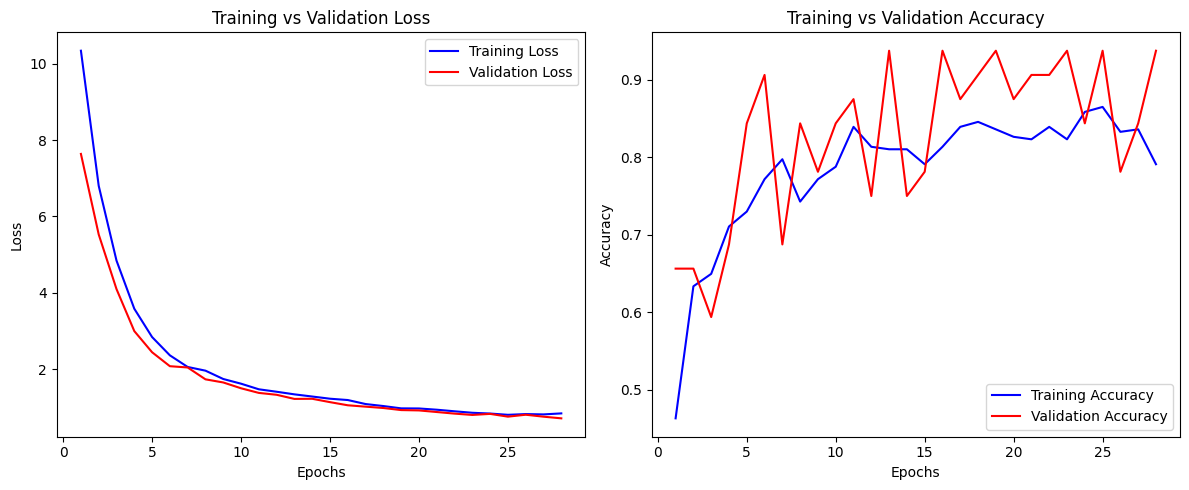

In [34]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

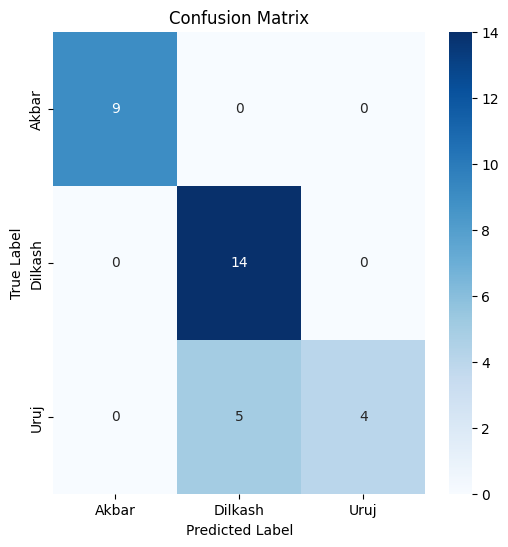

In [35]:
cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# GoogleNet

In [43]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.8
val_split = 0.1
test_split = 0.1

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Total images: 375
Train: 300, Val: 37, Test: 38


In [44]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

In [45]:
num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)


Epoch [1/50] Train Loss: 1.0830 Train Acc: 0.4067 Val Loss: 1.0362 Val Acc: 0.7838
Epoch [2/50] Train Loss: 1.0034 Train Acc: 0.5833 Val Loss: 0.9567 Val Acc: 0.8649
Epoch [3/50] Train Loss: 0.8953 Train Acc: 0.6833 Val Loss: 0.8793 Val Acc: 0.7568
Epoch [4/50] Train Loss: 0.8375 Train Acc: 0.7033 Val Loss: 0.7888 Val Acc: 0.8919
Epoch [5/50] Train Loss: 0.7775 Train Acc: 0.7467 Val Loss: 0.6934 Val Acc: 0.8919
Epoch [6/50] Train Loss: 0.7527 Train Acc: 0.7600 Val Loss: 0.6605 Val Acc: 0.8919
Epoch [7/50] Train Loss: 0.6986 Train Acc: 0.7600 Val Loss: 0.5998 Val Acc: 0.9189
Epoch [8/50] Train Loss: 0.6204 Train Acc: 0.7767 Val Loss: 0.5776 Val Acc: 0.9189
Epoch [9/50] Train Loss: 0.5757 Train Acc: 0.8367 Val Loss: 0.5252 Val Acc: 0.9459
Epoch [10/50] Train Loss: 0.5922 Train Acc: 0.7700 Val Loss: 0.4945 Val Acc: 0.9189
Epoch [11/50] Train Loss: 0.5456 Train Acc: 0.8367 Val Loss: 0.4607 Val Acc: 0.9189
Epoch [12/50] Train Loss: 0.5111 Train Acc: 0.8500 Val Loss: 0.4699 Val Acc: 0.9459
E

In [49]:
googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

Accuracy:  0.7895
Precision: 0.7982
Recall:    0.7895
F1-Score:  0.7930

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      0.92      0.96        13
     Dilkash       0.71      0.71      0.71        14
        Uruj       0.67      0.73      0.70        11

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.80      0.79      0.79        38



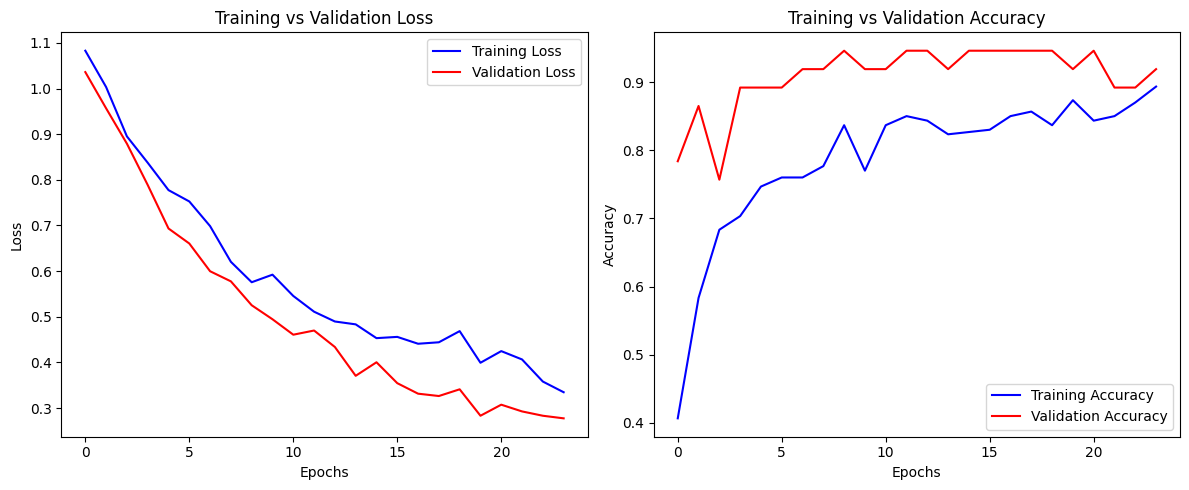

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

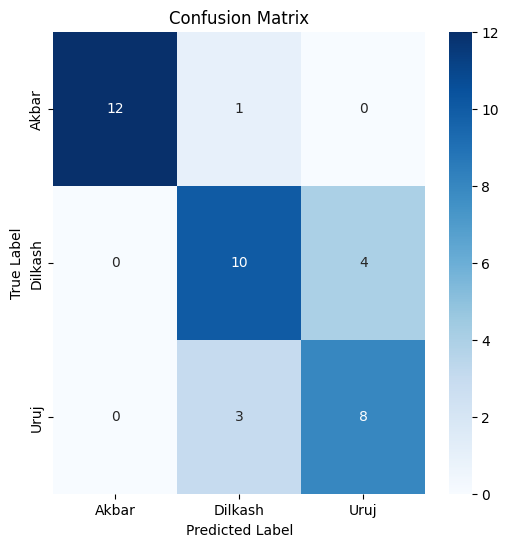

In [51]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Comparison

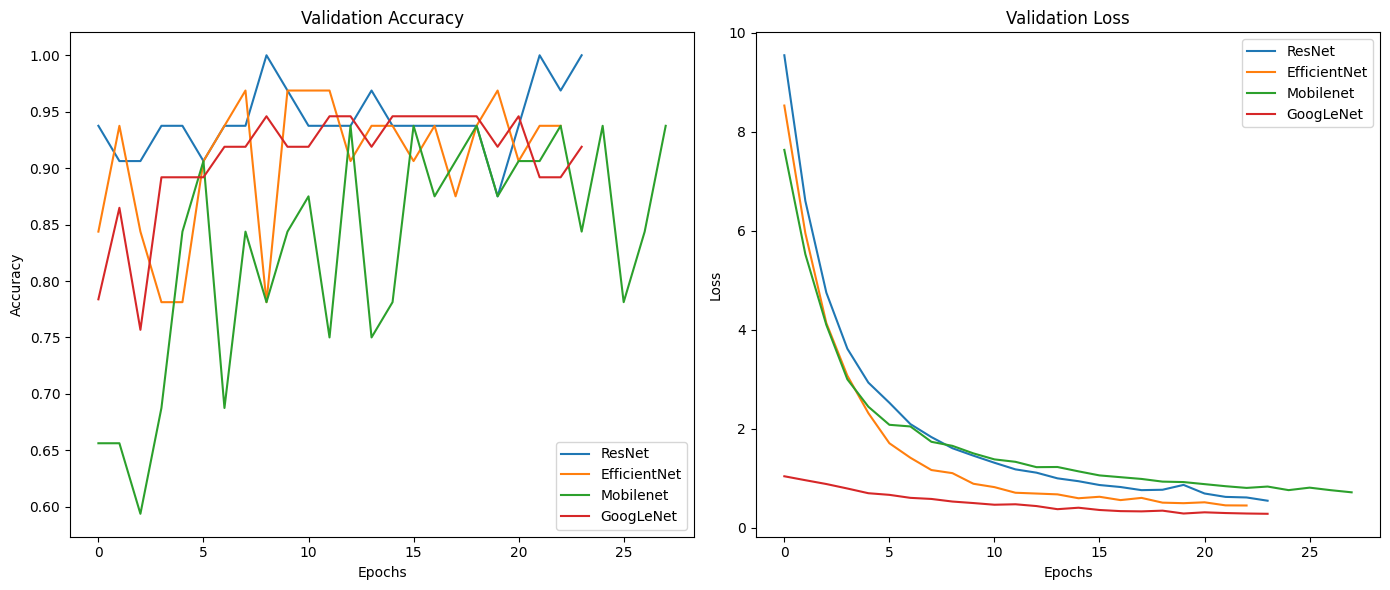

In [52]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


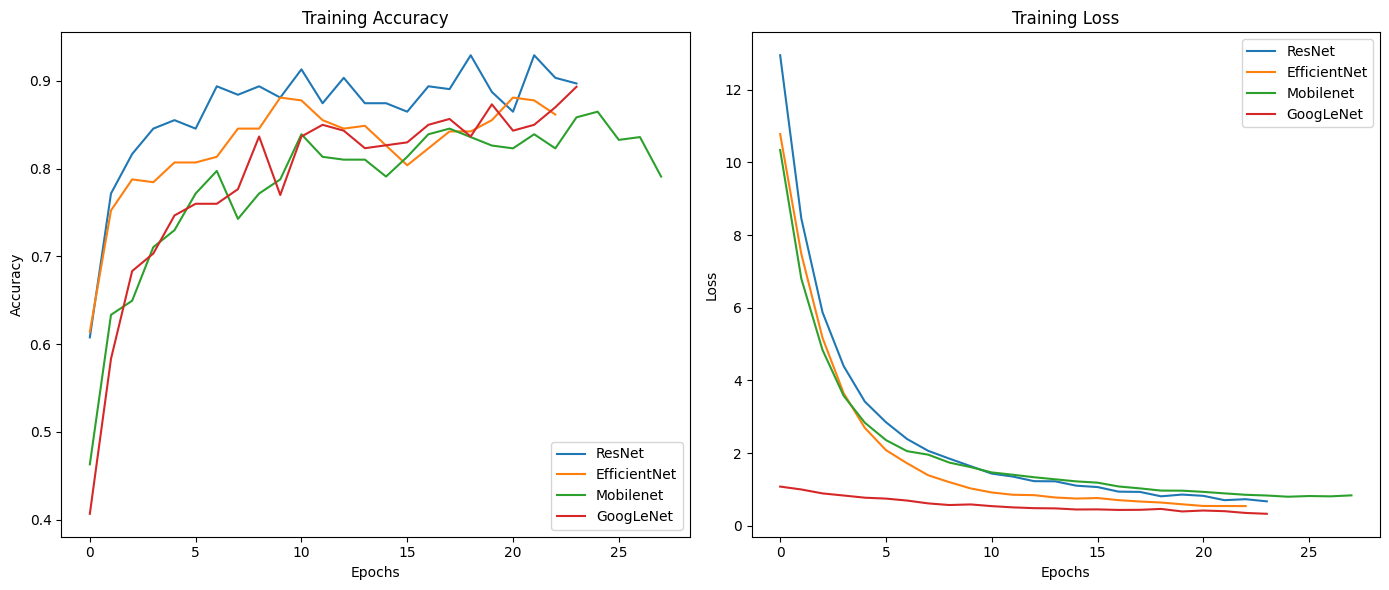

In [53]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test, Train (80,20)

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 375 files belonging to 3 classes.


In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False


FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 989ms/step - accuracy: 0.4908 - loss: 15.3832 - val_accuracy: 0.7188 - val_loss: 10.5239
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6618 - loss: 9.9370 - val_accuracy: 0.9062 - val_loss: 7.4532
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7387 - loss: 7.3841 - val_accuracy: 0.6875 - val_loss: 5.9948
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7964 - loss: 5.5040 - val_accuracy: 0.9062 - val_loss: 4.4663
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8326 - loss: 4.3141 - val_accuracy: 0.8750 - val_loss: 3.6408
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8569 - loss: 3.5608 - val_accuracy: 0.8750 - val_loss: 3.0632
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8711 - loss: 3.0222 - val_accuracy: 0.7500 - val_loss: 2.7946
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8588 - loss: 2.6901 - val_accuracy: 0.8750 - val_loss: 2.3

Accuracy:  0.9219
Precision: 0.9281
Recall:    0.9219
F1-Score:  0.9220

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        22
     Dilkash       0.95      0.83      0.88        23
        Uruj       0.82      0.95      0.88        19

    accuracy                           0.92        64
   macro avg       0.92      0.92      0.92        64
weighted avg       0.93      0.92      0.92        64



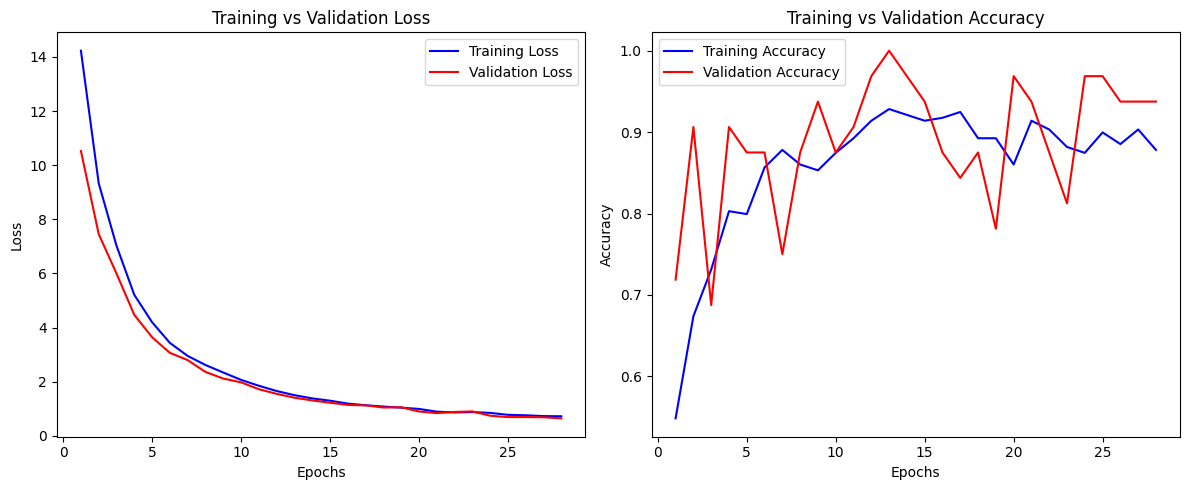

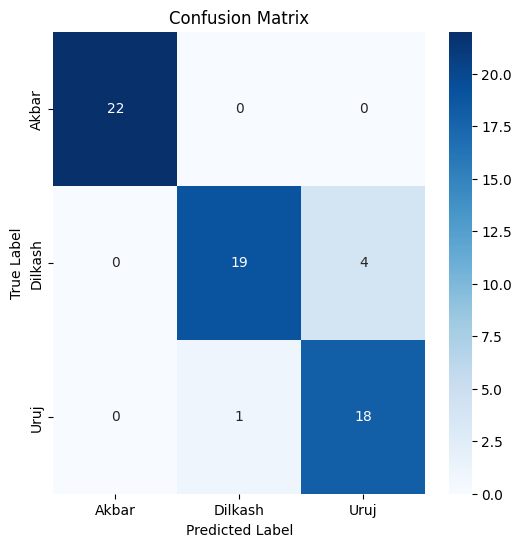

In [21]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [22]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)


efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4705 - loss: 11.9015 - val_accuracy: 0.7500 - val_loss: 9.2128
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7297 - loss: 8.8257 - val_accuracy: 0.7500 - val_loss: 7.0923
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8036 - loss: 6.4920 - val_accuracy: 0.7812 - val_loss: 5.1315
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7976 - loss: 4.8441 - val_accuracy: 0.8750 - val_loss: 3.8589
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8145 - loss: 3.6803 - val_accuracy: 0.8438 - val_loss: 2.9739
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8459 - loss: 2.8258 - val_accuracy: 0.8125 - val_loss: 2.4342
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8397 - loss: 2.3054 - val_accuracy: 0.8438 - val_loss: 1.9540
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7971 - loss

Accuracy:  0.9844
Precision: 0.9850
Recall:    0.9844
F1-Score:  0.9843

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        22
     Dilkash       0.96      1.00      0.98        23
        Uruj       1.00      0.95      0.97        19

    accuracy                           0.98        64
   macro avg       0.99      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64



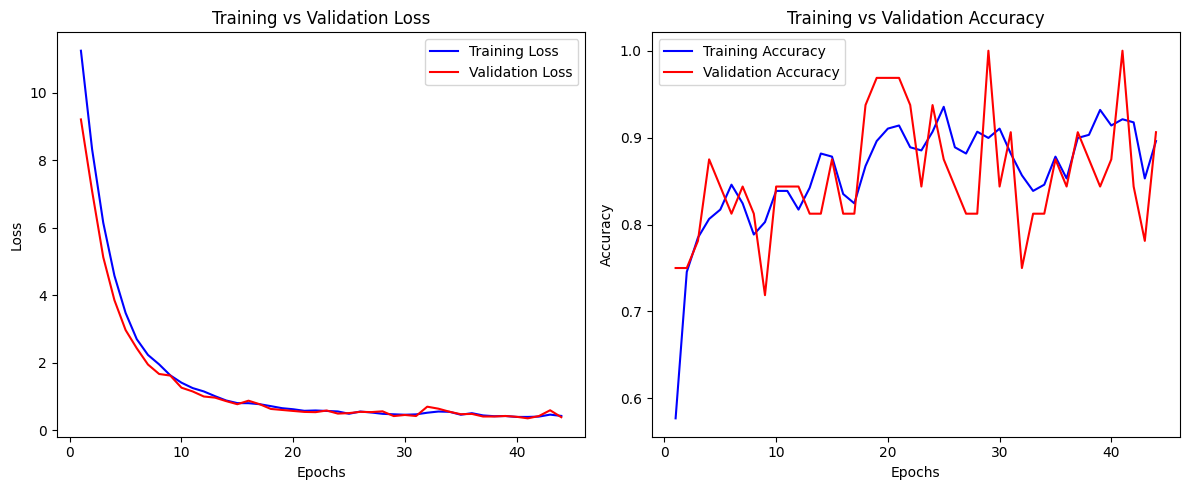

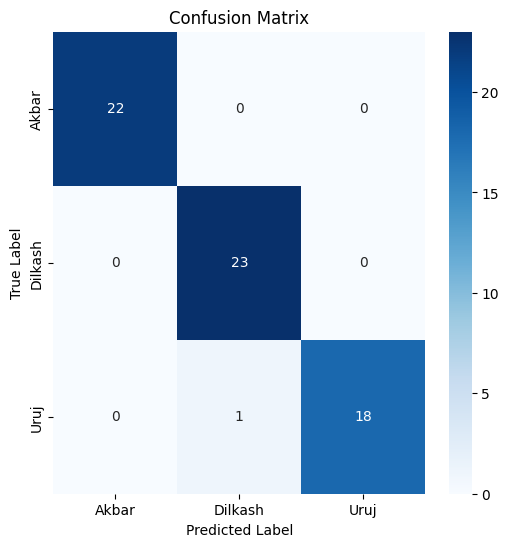

In [23]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = efficientnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [24]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 597ms/step - accuracy: 0.3096 - loss: 11.6481 - val_accuracy: 0.6875 - val_loss: 7.9373
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6150 - loss: 7.6850 - val_accuracy: 0.7188 - val_loss: 5.7686
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6911 - loss: 5.4830 - val_accuracy: 0.7188 - val_loss: 4.2083
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7052 - loss: 4.1038 - val_accuracy: 0.7500 - val_loss: 3.3228
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7405 - loss: 3.2545 - val_accuracy: 0.6250 - val_loss: 2.8797
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7366 - loss: 2.7004 - val_accuracy: 0.7812 - val_loss: 2.3779
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8121 - loss: 2.2768 - val_accuracy: 0.8438 - val_loss: 2.1097
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8184 - l

Accuracy:  0.9219
Precision: 0.9228
Recall:    0.9219
F1-Score:  0.9220

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        22
     Dilkash       0.91      0.87      0.89        23
        Uruj       0.85      0.89      0.87        19

    accuracy                           0.92        64
   macro avg       0.92      0.92      0.92        64
weighted avg       0.92      0.92      0.92        64



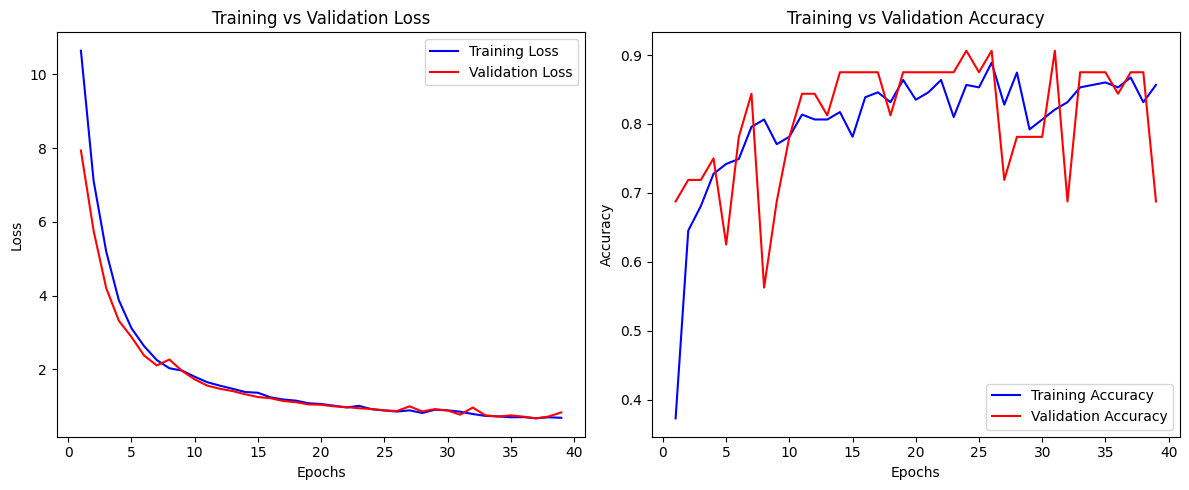

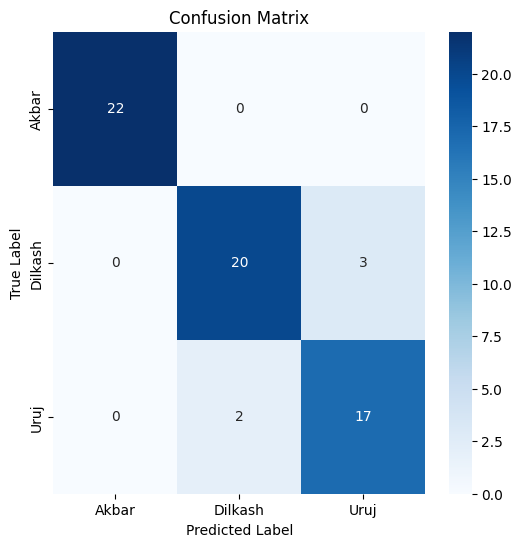

In [25]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [26]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.7
val_split = 0.1
test_split = 0.2

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")



Total images: 375
Train: 262, Val: 37, Test: 76


In [27]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 160MB/s]


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)


googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

Epoch [1/50] Train Loss: 1.0733 Train Acc: 0.4542 Val Loss: 1.0047 Val Acc: 0.8378
Epoch [2/50] Train Loss: 0.9670 Train Acc: 0.5992 Val Loss: 0.8910 Val Acc: 0.7297
Epoch [3/50] Train Loss: 0.8890 Train Acc: 0.6947 Val Loss: 0.7934 Val Acc: 0.8378
Epoch [4/50] Train Loss: 0.8502 Train Acc: 0.6718 Val Loss: 0.7046 Val Acc: 0.8919
Epoch [5/50] Train Loss: 0.7962 Train Acc: 0.7252 Val Loss: 0.6115 Val Acc: 0.8108
Epoch [6/50] Train Loss: 0.7659 Train Acc: 0.7481 Val Loss: 0.5426 Val Acc: 0.8378
Epoch [7/50] Train Loss: 0.7350 Train Acc: 0.7405 Val Loss: 0.5109 Val Acc: 0.8649
Epoch [8/50] Train Loss: 0.6535 Train Acc: 0.7977 Val Loss: 0.4756 Val Acc: 0.8649
Epoch [9/50] Train Loss: 0.6163 Train Acc: 0.7824 Val Loss: 0.4487 Val Acc: 0.8649
Epoch [10/50] Train Loss: 0.5857 Train Acc: 0.8130 Val Loss: 0.4122 Val Acc: 0.8919
Epoch [11/50] Train Loss: 0.5605 Train Acc: 0.8244 Val Loss: 0.3851 Val Acc: 0.8378
Epoch [12/50] Train Loss: 0.6168 Train Acc: 0.8015 Val Loss: 0.3723 Val Acc: 0.8108
E

Accuracy:  0.8158
Precision: 0.8189
Recall:    0.8158
F1-Score:  0.8171

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      0.95      0.98        22
     Dilkash       0.72      0.72      0.72        25
        Uruj       0.77      0.79      0.78        29

    accuracy                           0.82        76
   macro avg       0.83      0.82      0.83        76
weighted avg       0.82      0.82      0.82        76



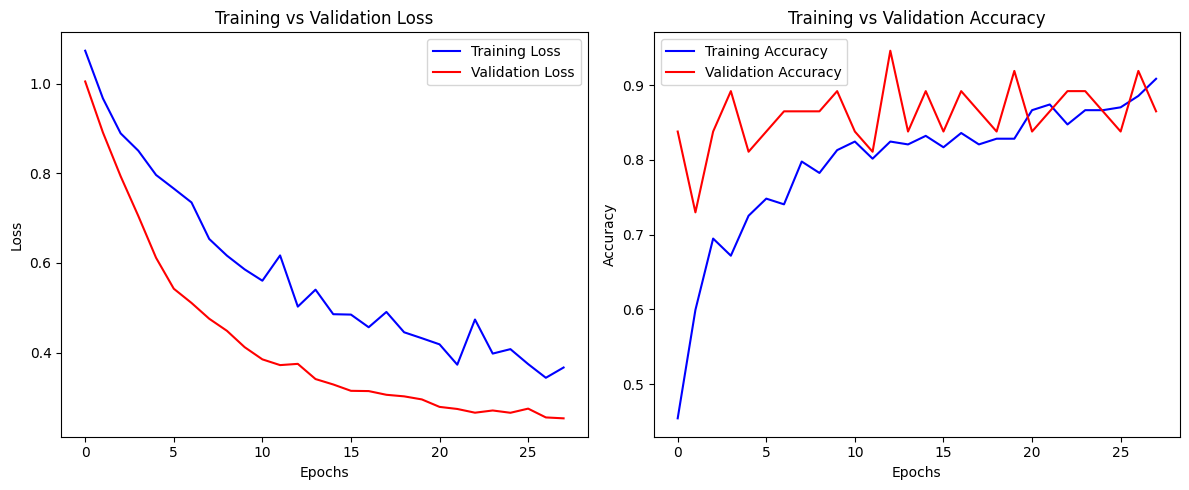

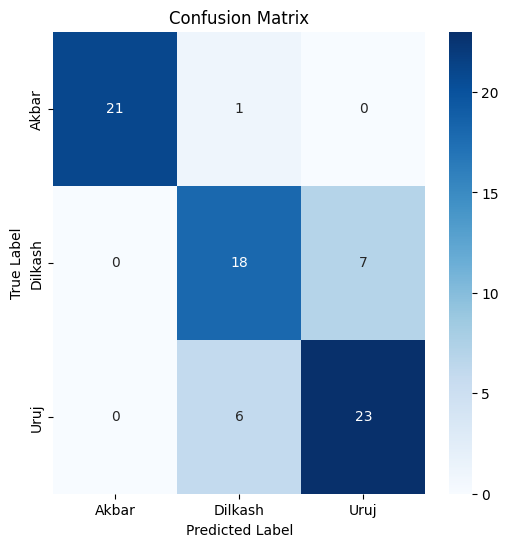

In [29]:
true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

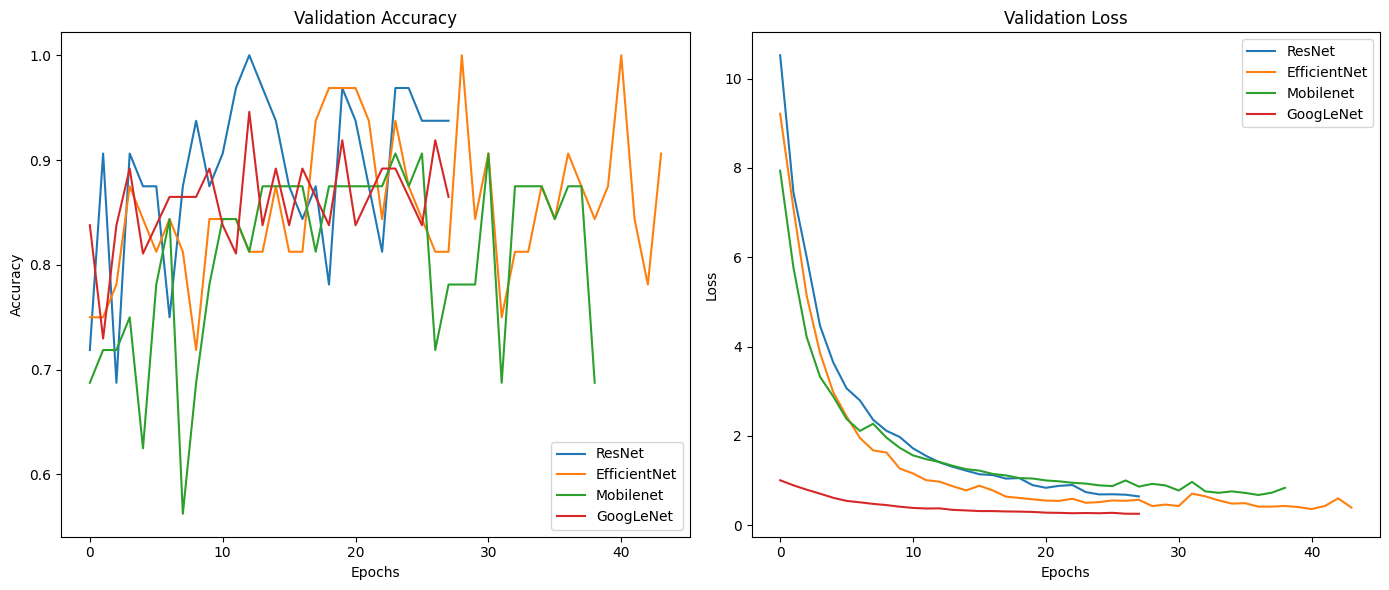

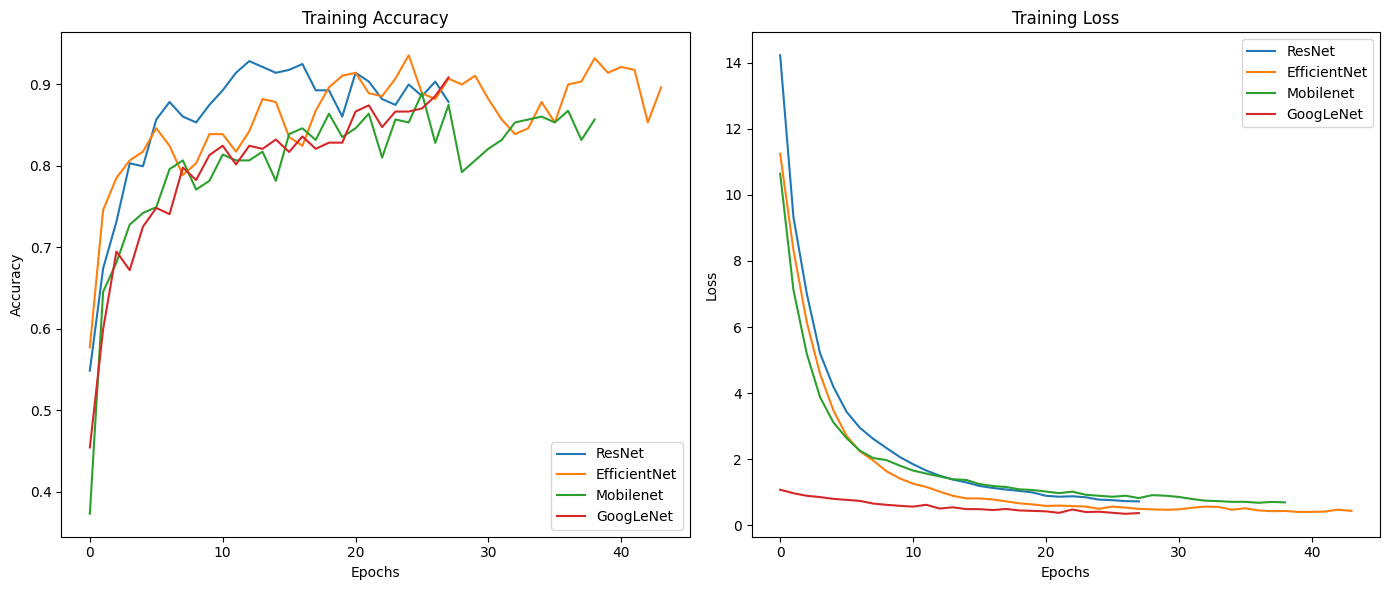

In [30]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Train, Test (70,30)

In [31]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.3, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 375 files belonging to 3 classes.


In [32]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False


FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4913 - loss: 14.5108 - val_accuracy: 0.7812 - val_loss: 10.6461
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7005 - loss: 10.3339 - val_accuracy: 0.8750 - val_loss: 7.8915
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7856 - loss: 7.6340 - val_accuracy: 0.8438 - val_loss: 5.9812
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7687 - loss: 5.9922 - val_accuracy: 0.8438 - val_loss: 4.8980
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8046 - loss: 4.6764 - val_accuracy: 0.8125 - val_loss: 4.1247
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8567 - loss: 3.8602 - val_accuracy: 0.9688 - val_loss: 3.2943
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8809 - loss: 3.2525 - val_accuracy: 0.9375 - val_loss: 2.8467
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8492 - loss: 2.8901 - val_accuracy: 0.9375 - val_loss: 2.552

Accuracy:  0.9375
Precision: 0.9471
Recall:    0.9375
F1-Score:  0.9368

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        32
     Dilkash       1.00      0.81      0.89        31
        Uruj       0.85      1.00      0.92        33

    accuracy                           0.94        96
   macro avg       0.95      0.94      0.94        96
weighted avg       0.95      0.94      0.94        96



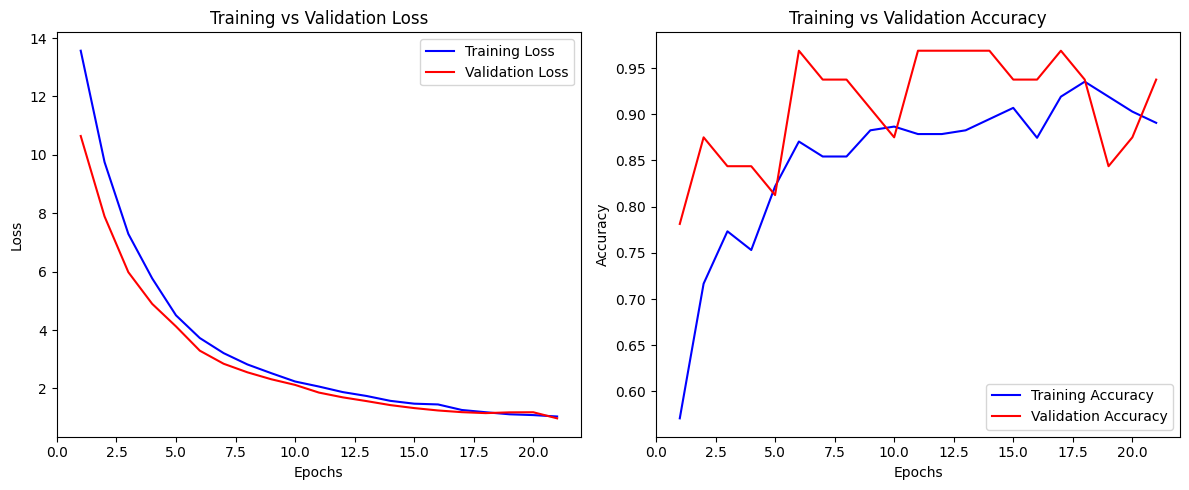

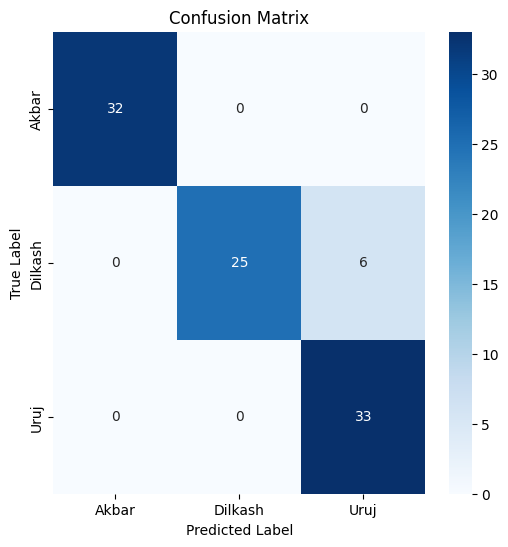

In [33]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [34]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)


efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5328 - loss: 11.8249 - val_accuracy: 0.6875 - val_loss: 9.3285
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7066 - loss: 8.7314 - val_accuracy: 0.8125 - val_loss: 6.8413
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8296 - loss: 6.4066 - val_accuracy: 0.7188 - val_loss: 5.0865
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8145 - loss: 4.7576 - val_accuracy: 0.9375 - val_loss: 3.7178
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8521 - loss: 3.5370 - val_accuracy: 0.8750 - val_loss: 2.8103
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8658 - loss: 2.6933 - val_accuracy: 0.9062 - val_loss: 2.2221
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8832 - loss: 2.1387 - val_accuracy: 0.9375 - val_loss: 1.7914
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8115 - loss: 1.8535 - val_accuracy: 0.8750 - val_loss: 1.4568


Accuracy:  0.9062
Precision: 0.9178
Recall:    0.9062
F1-Score:  0.9048

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        32
     Dilkash       0.96      0.74      0.84        31
        Uruj       0.80      0.97      0.88        33

    accuracy                           0.91        96
   macro avg       0.92      0.90      0.90        96
weighted avg       0.92      0.91      0.90        96



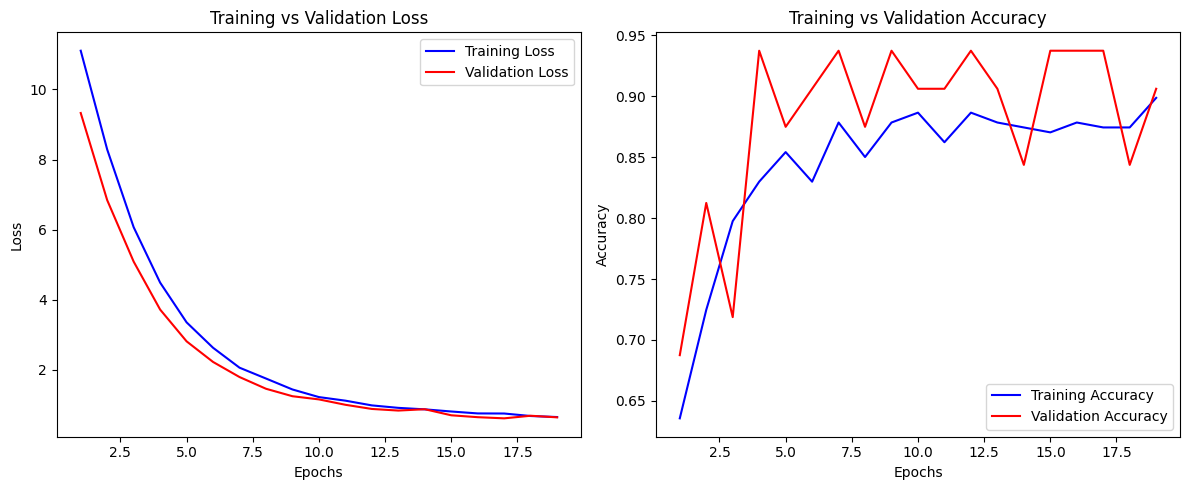

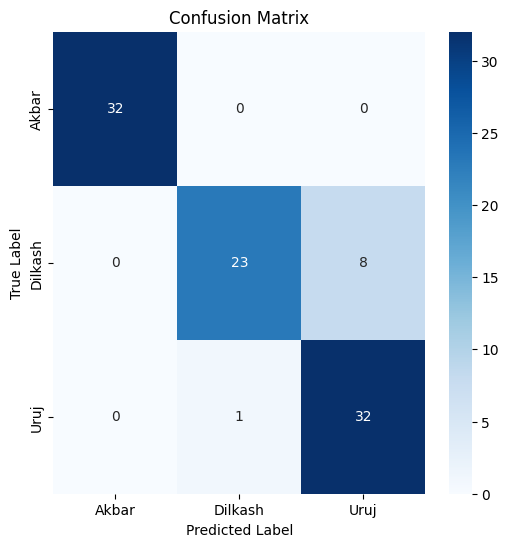

In [35]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = efficientnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 545ms/step - accuracy: 0.4481 - loss: 11.1944 - val_accuracy: 0.7500 - val_loss: 7.9450
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6127 - loss: 7.8075 - val_accuracy: 0.8438 - val_loss: 5.7170
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7276 - loss: 5.6363 - val_accuracy: 0.8750 - val_loss: 4.2665
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6843 - loss: 4.3411 - val_accuracy: 0.8125 - val_loss: 3.2656
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7503 - loss: 3.3282 - val_accuracy: 0.8438 - val_loss: 2.7367
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7349 - loss: 2.7281 - val_accuracy: 0.8750 - val_loss: 2.2676
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7729 - loss: 2.3107 - val_accuracy: 0.8438 - val_loss: 1.9324
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7769 - loss: 2.0194 - val_accuracy: 0.8125 - val_loss: 1.73

Accuracy:  0.8854
Precision: 0.8957
Recall:    0.8854
F1-Score:  0.8836

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        32
     Dilkash       0.92      0.71      0.80        31
        Uruj       0.78      0.94      0.85        33

    accuracy                           0.89        96
   macro avg       0.90      0.88      0.88        96
weighted avg       0.90      0.89      0.88        96



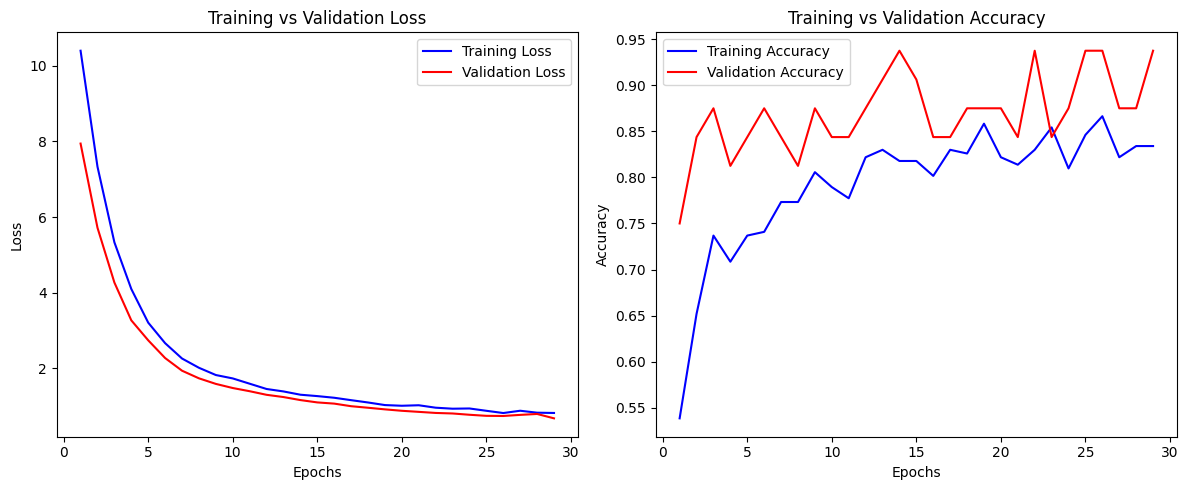

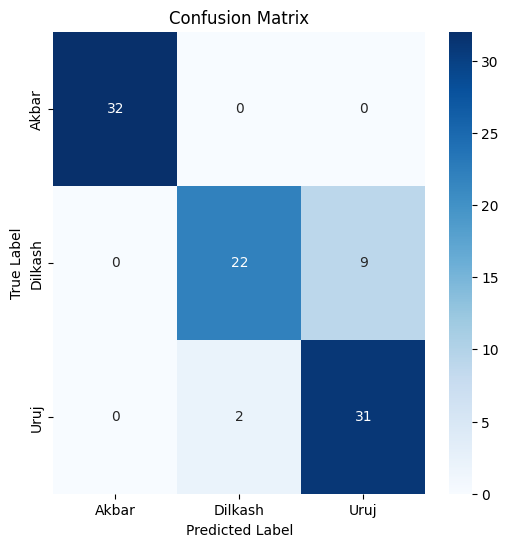

In [37]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [38]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.6
val_split = 0.1
test_split = 0.3

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Total images: 375
Train: 225, Val: 37, Test: 113


In [39]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)



Epoch [1/50] Train Loss: 1.0957 Train Acc: 0.3289 Val Loss: 1.0714 Val Acc: 0.5946
Epoch [2/50] Train Loss: 1.0392 Train Acc: 0.5822 Val Loss: 0.9992 Val Acc: 0.6757
Epoch [3/50] Train Loss: 0.9409 Train Acc: 0.7156 Val Loss: 0.9065 Val Acc: 0.7027
Epoch [4/50] Train Loss: 0.8969 Train Acc: 0.6356 Val Loss: 0.8465 Val Acc: 0.7027
Epoch [5/50] Train Loss: 0.8783 Train Acc: 0.7022 Val Loss: 0.7976 Val Acc: 0.6216
Epoch [6/50] Train Loss: 0.8632 Train Acc: 0.7156 Val Loss: 0.7933 Val Acc: 0.7027
Epoch [7/50] Train Loss: 0.8518 Train Acc: 0.7289 Val Loss: 0.7792 Val Acc: 0.7027
Epoch [8/50] Train Loss: 0.7962 Train Acc: 0.7422 Val Loss: 0.7074 Val Acc: 0.7297
Epoch [9/50] Train Loss: 0.8113 Train Acc: 0.7422 Val Loss: 0.6893 Val Acc: 0.7027
Epoch [10/50] Train Loss: 0.7542 Train Acc: 0.7644 Val Loss: 0.6768 Val Acc: 0.7568
Epoch [11/50] Train Loss: 0.7169 Train Acc: 0.7822 Val Loss: 0.6460 Val Acc: 0.7027
Epoch [12/50] Train Loss: 0.6589 Train Acc: 0.7289 Val Loss: 0.6247 Val Acc: 0.6486
E

Accuracy:  0.8584
Precision: 0.8671
Recall:    0.8584
F1-Score:  0.8598

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.97      0.95      0.96        40
     Dilkash       0.73      0.86      0.79        35
        Uruj       0.88      0.76      0.82        38

    accuracy                           0.86       113
   macro avg       0.86      0.86      0.86       113
weighted avg       0.87      0.86      0.86       113



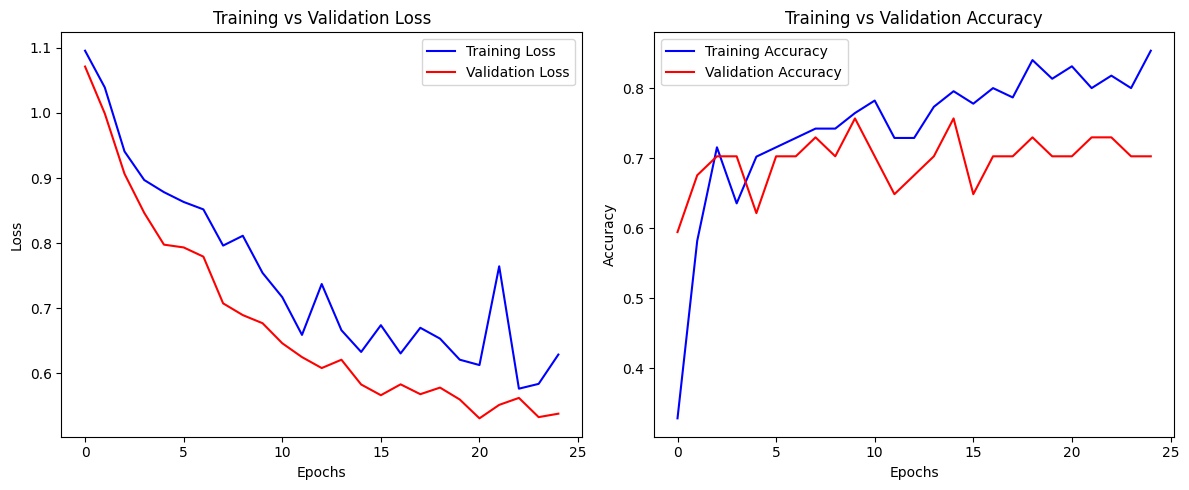

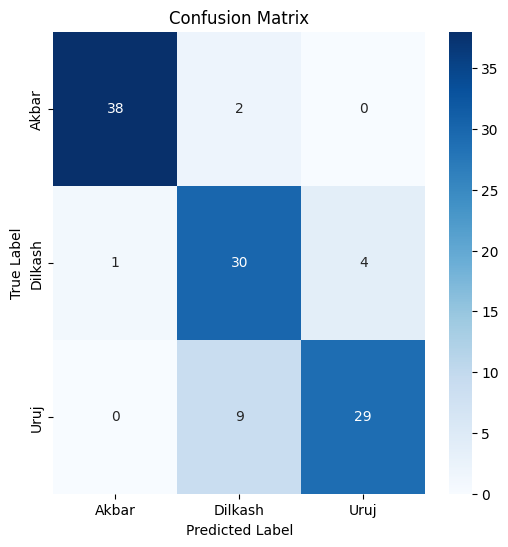

In [40]:
googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


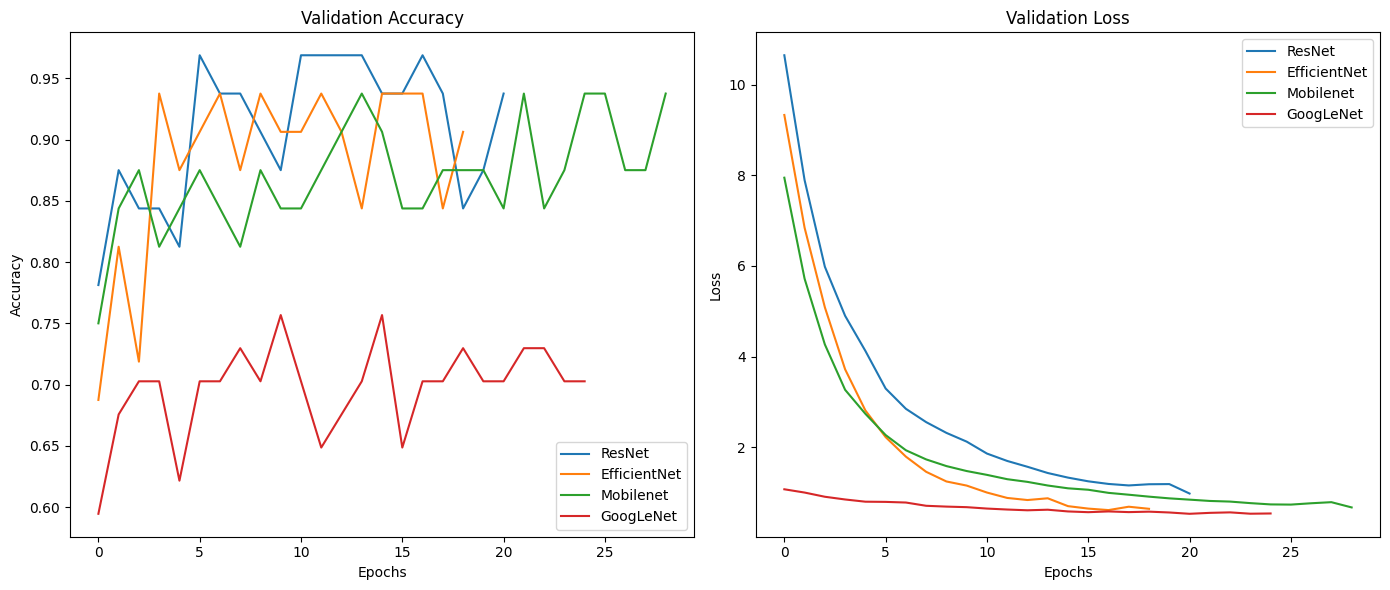

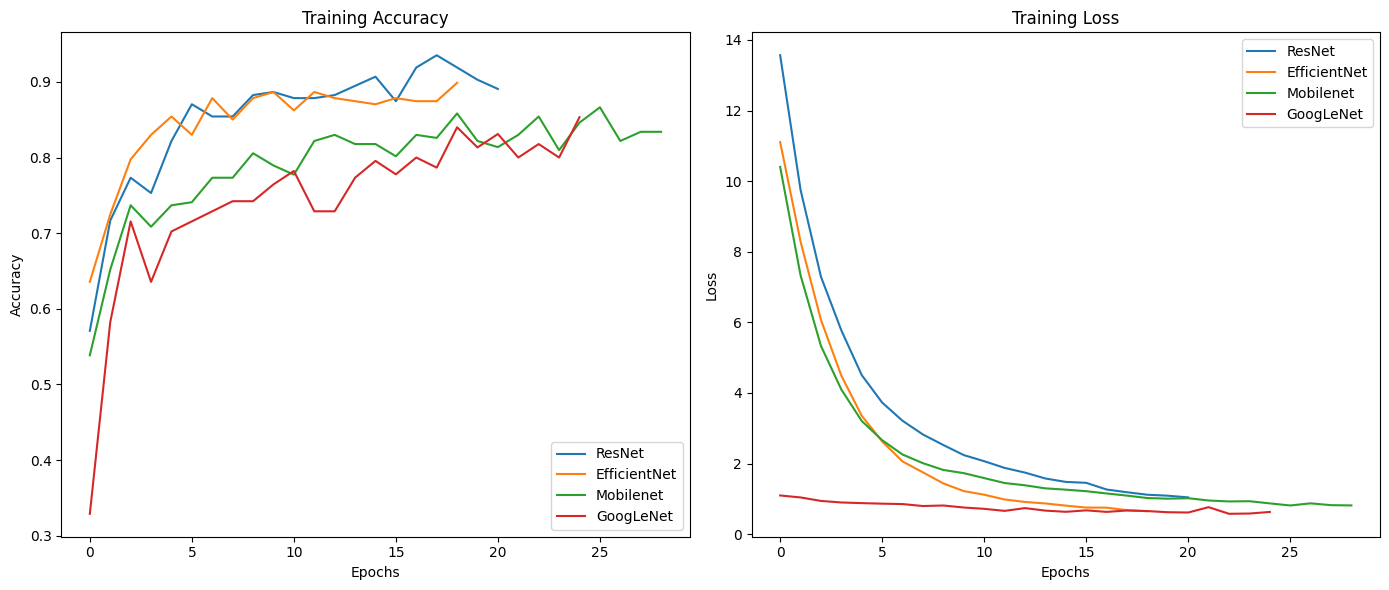

In [41]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Train, Test (60,40)

In [42]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.1, test_split=0.4, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 375 files belonging to 3 classes.


In [43]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False


FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4566 - loss: 14.9536 - val_accuracy: 0.7188 - val_loss: 11.3932
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7529 - loss: 10.7142 - val_accuracy: 0.8125 - val_loss: 8.5386
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7869 - loss: 7.9820 - val_accuracy: 0.8438 - val_loss: 6.6073
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8125 - loss: 6.2261 - val_accuracy: 0.8750 - val_loss: 5.2274
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8010 - loss: 5.0521 - val_accuracy: 0.8438 - val_loss: 4.4108
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8761 - loss: 4.0100 - val_accuracy: 0.8125 - val_loss: 3.6383
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9173 - loss: 3.3441 - val_accuracy: 0.8125 - val_loss: 3.1884
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8624 - loss: 3.0295 - val_accuracy: 0.8438 - val_loss: 2.832

Accuracy:  0.9453
Precision: 0.9456
Recall:    0.9453
F1-Score:  0.9454

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        45
     Dilkash       0.93      0.91      0.92        45
        Uruj       0.90      0.92      0.91        38

    accuracy                           0.95       128
   macro avg       0.94      0.94      0.94       128
weighted avg       0.95      0.95      0.95       128



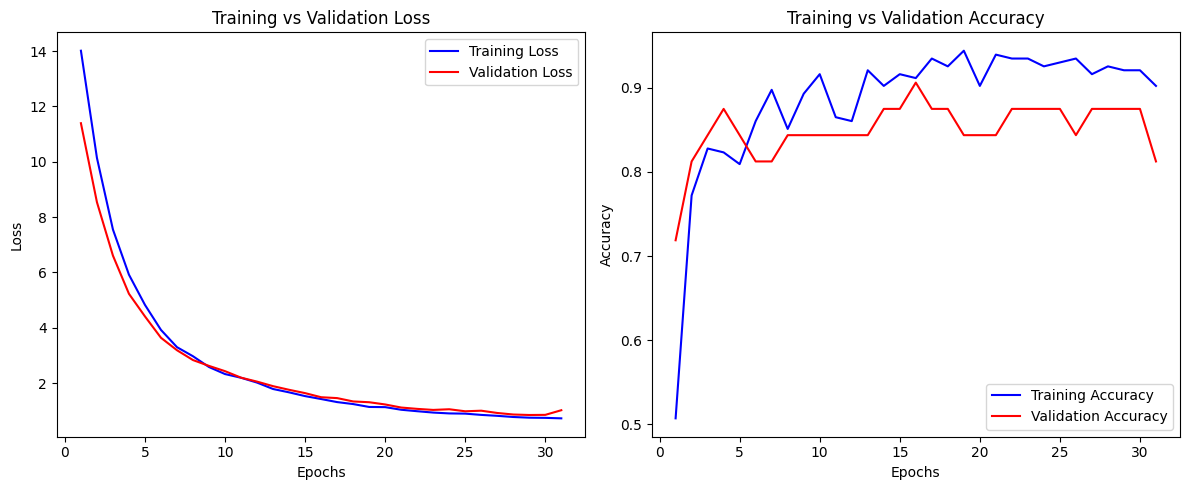

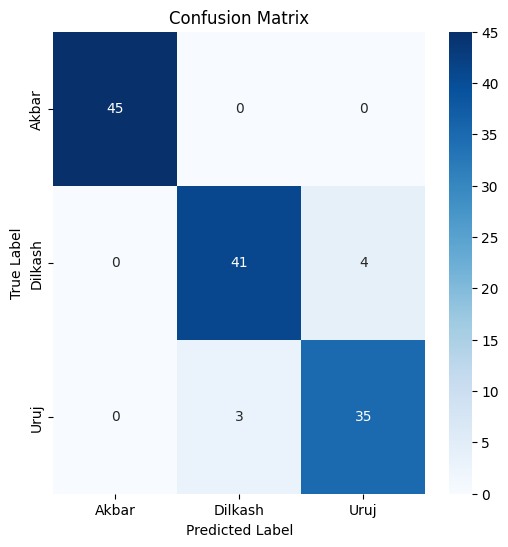

In [44]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [45]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)


efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5122 - loss: 11.7890 - val_accuracy: 0.7188 - val_loss: 9.5442
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7178 - loss: 9.0384 - val_accuracy: 0.8125 - val_loss: 7.3443
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7688 - loss: 6.9687 - val_accuracy: 0.7812 - val_loss: 5.6407
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8085 - loss: 5.3482 - val_accuracy: 0.8125 - val_loss: 4.3313
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8009 - loss: 4.0535 - val_accuracy: 0.7812 - val_loss: 3.4212
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8276 - loss: 3.2057 - val_accuracy: 0.8125 - val_loss: 2.6857
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8623 - loss: 2.5189 - val_accuracy: 0.8750 - val_loss: 2.1200
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8353 - loss: 2.1275 - val_accuracy: 0.8750 - val_loss: 1.7673


Accuracy:  0.9453
Precision: 0.9456
Recall:    0.9453
F1-Score:  0.9454

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        45
     Dilkash       0.93      0.91      0.92        45
        Uruj       0.90      0.92      0.91        38

    accuracy                           0.95       128
   macro avg       0.94      0.94      0.94       128
weighted avg       0.95      0.95      0.95       128



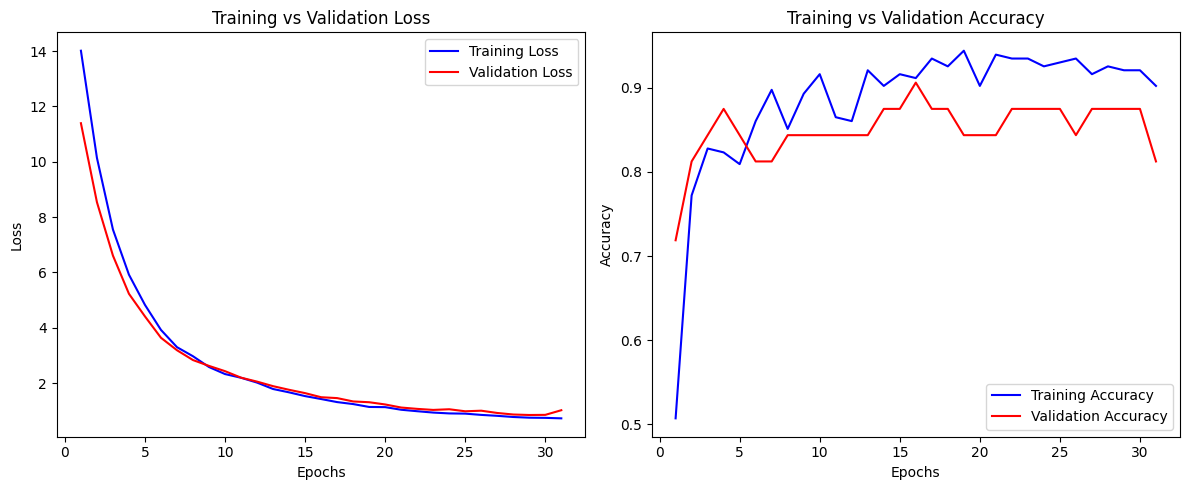

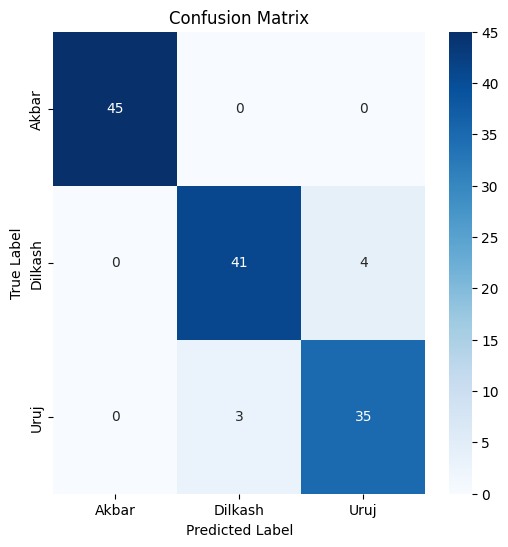

In [46]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [47]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 633ms/step - accuracy: 0.4279 - loss: 11.2327 - val_accuracy: 0.5938 - val_loss: 8.5461
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5656 - loss: 8.2427 - val_accuracy: 0.7500 - val_loss: 6.2826
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6871 - loss: 6.1632 - val_accuracy: 0.7812 - val_loss: 4.8156
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6881 - loss: 4.6706 - val_accuracy: 0.8125 - val_loss: 3.7720
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7705 - loss: 3.6331 - val_accuracy: 0.6875 - val_loss: 3.1807
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7032 - loss: 3.0327 - val_accuracy: 0.8438 - val_loss: 2.5475
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7798 - loss: 2.5192 - val_accuracy: 0.8125 - val_loss: 2.2080
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7838 - loss: 2.2258 - val_accuracy: 0.8438 - val_loss: 1.981

Accuracy:  0.8359
Precision: 0.8640
Recall:    0.8359
F1-Score:  0.8253

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        45
     Dilkash       0.69      0.96      0.80        45
        Uruj       0.90      0.50      0.64        38

    accuracy                           0.84       128
   macro avg       0.87      0.82      0.82       128
weighted avg       0.86      0.84      0.83       128



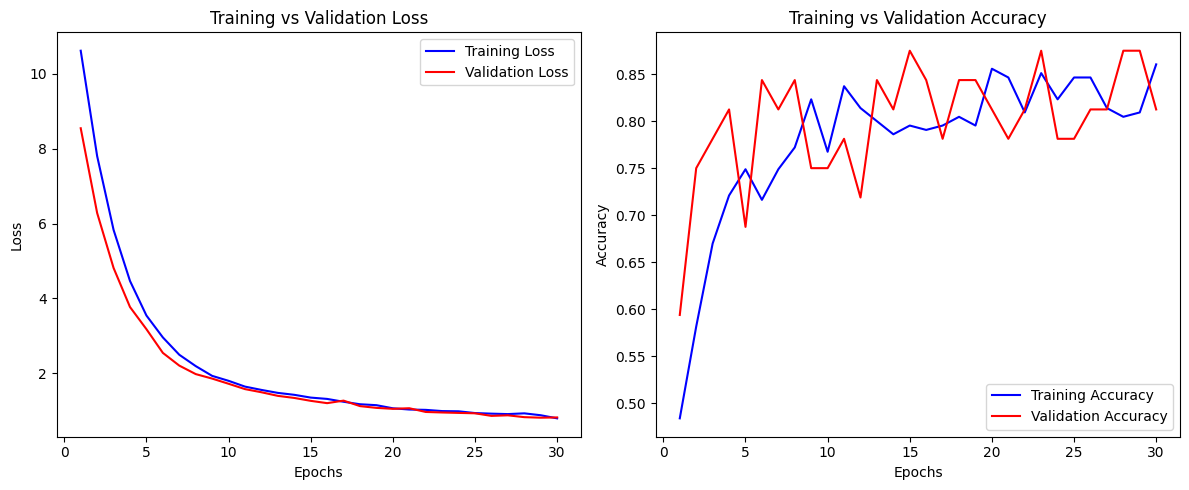

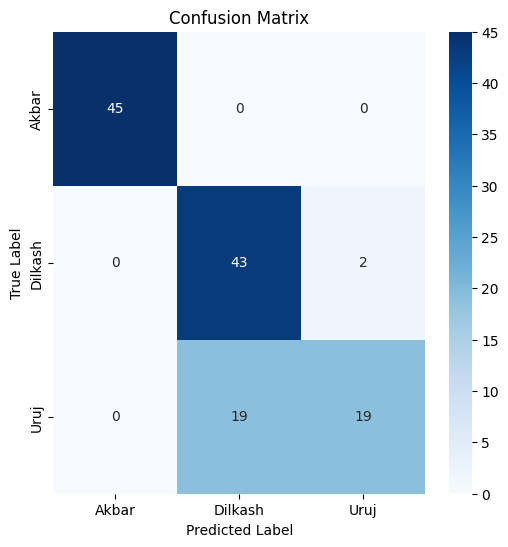

In [48]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [49]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.6
val_split = 0.1
test_split = 0.3

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Total images: 375
Train: 225, Val: 37, Test: 113


In [50]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)


Epoch [1/50] Train Loss: 1.0603 Train Acc: 0.5200 Val Loss: 1.0581 Val Acc: 0.4595
Epoch [2/50] Train Loss: 0.9726 Train Acc: 0.6356 Val Loss: 1.0479 Val Acc: 0.4865
Epoch [3/50] Train Loss: 0.9997 Train Acc: 0.6400 Val Loss: 1.0068 Val Acc: 0.4865
Epoch [4/50] Train Loss: 0.9011 Train Acc: 0.6933 Val Loss: 0.8975 Val Acc: 0.5946
Epoch [5/50] Train Loss: 0.8534 Train Acc: 0.7333 Val Loss: 0.8610 Val Acc: 0.6486
Epoch [6/50] Train Loss: 0.7847 Train Acc: 0.7867 Val Loss: 0.8591 Val Acc: 0.5676
Epoch [7/50] Train Loss: 0.7170 Train Acc: 0.7378 Val Loss: 0.8740 Val Acc: 0.5135
Epoch [8/50] Train Loss: 0.7106 Train Acc: 0.7289 Val Loss: 0.8347 Val Acc: 0.5135
Epoch [9/50] Train Loss: 0.7516 Train Acc: 0.7422 Val Loss: 0.7946 Val Acc: 0.6216
Epoch [10/50] Train Loss: 0.6925 Train Acc: 0.8000 Val Loss: 0.7270 Val Acc: 0.6486
Epoch [11/50] Train Loss: 0.6744 Train Acc: 0.8089 Val Loss: 0.7159 Val Acc: 0.6486
Epoch [12/50] Train Loss: 0.7128 Train Acc: 0.8222 Val Loss: 0.7330 Val Acc: 0.7027
E

Accuracy:  0.8359
Precision: 0.8640
Recall:    0.8359
F1-Score:  0.8253

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        45
     Dilkash       0.69      0.96      0.80        45
        Uruj       0.90      0.50      0.64        38

    accuracy                           0.84       128
   macro avg       0.87      0.82      0.82       128
weighted avg       0.86      0.84      0.83       128



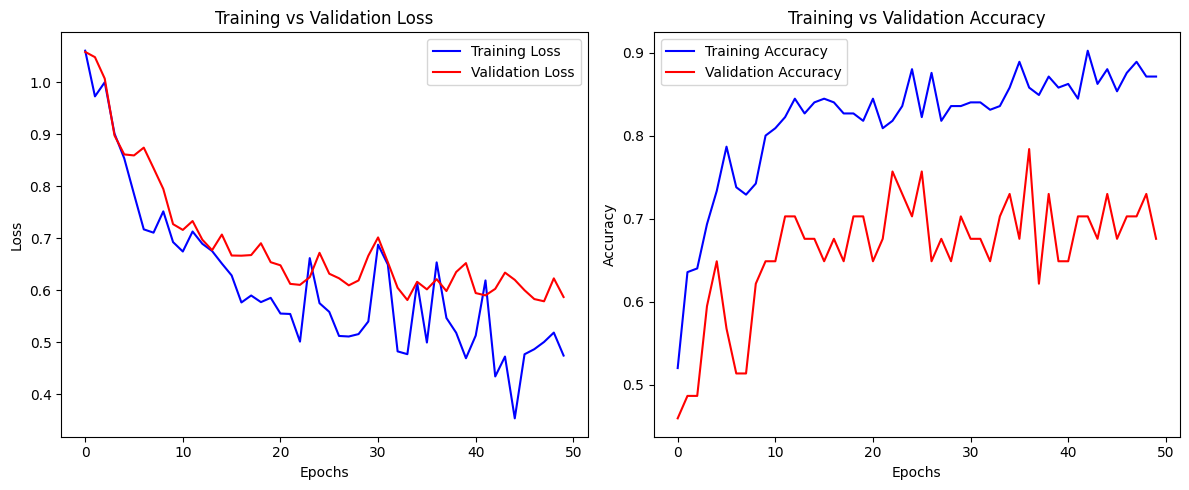

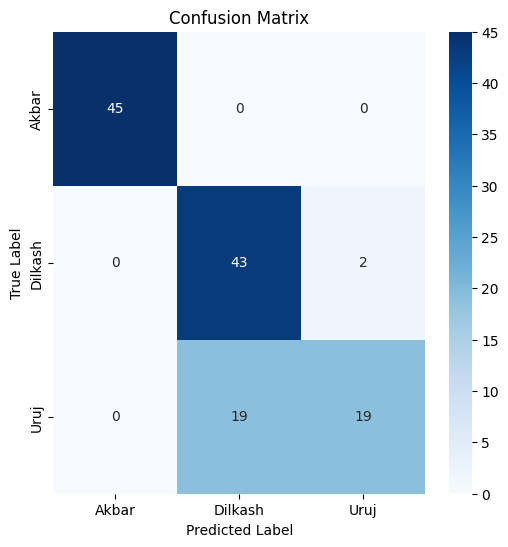

In [52]:
true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


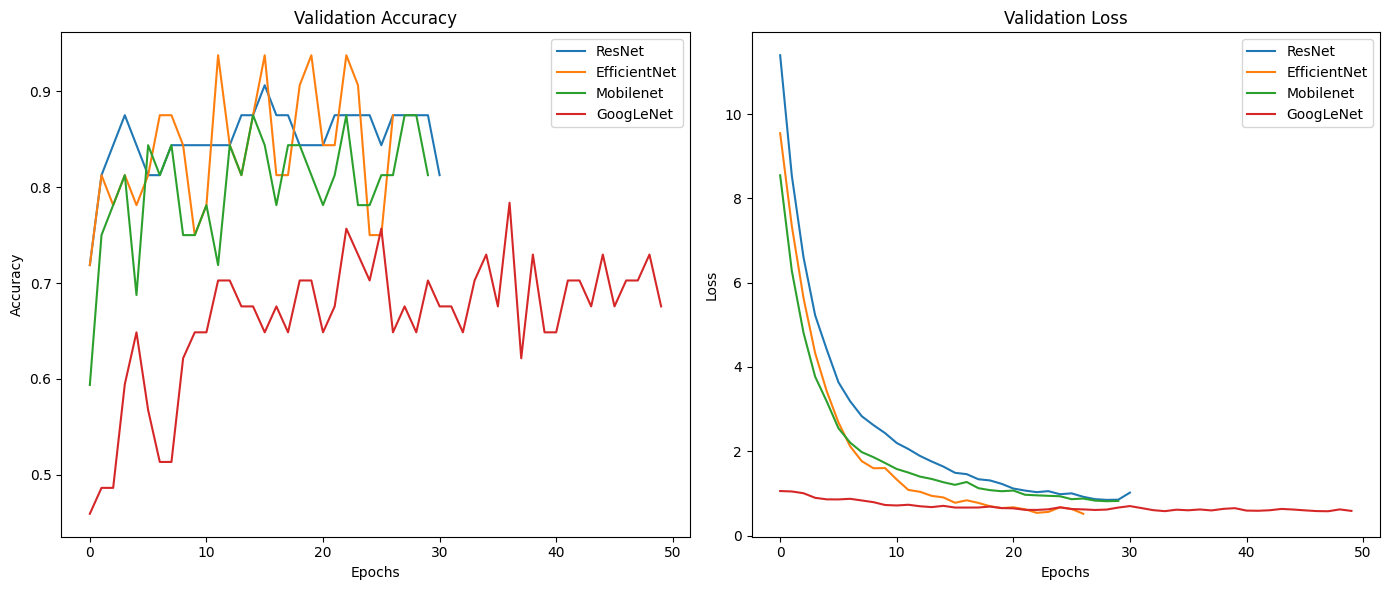

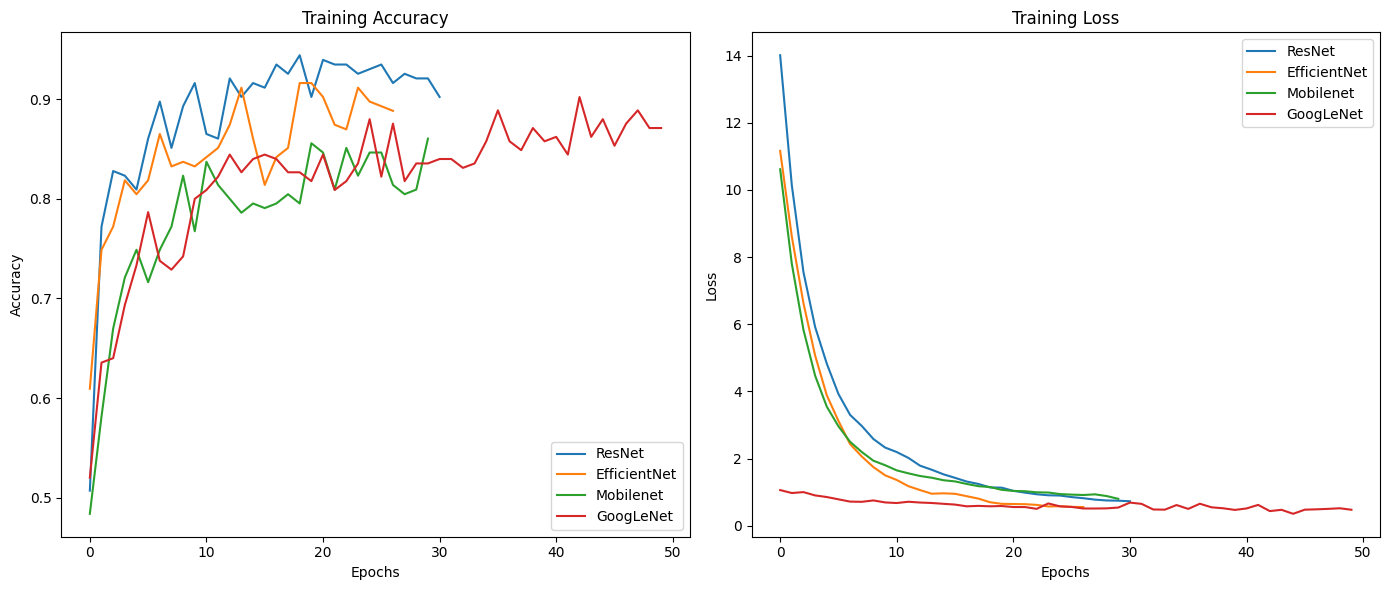

In [53]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Train, Test (50,50)

In [60]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def get_dataset_partitions_tf(ds, train_split=0.5, val_split=0.1, test_split=0.5, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 375 files belonging to 3 classes.


In [61]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False


FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4163 - loss: 15.4257 - val_accuracy: 0.7188 - val_loss: 11.4919
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7099 - loss: 11.1973 - val_accuracy: 0.8438 - val_loss: 9.1811
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7836 - loss: 8.8949 - val_accuracy: 0.6875 - val_loss: 7.5923
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7861 - loss: 7.1771 - val_accuracy: 0.8750 - val_loss: 6.0414
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8167 - loss: 5.8619 - val_accuracy: 0.7188 - val_loss: 5.2050
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8100 - loss: 4.9508 - val_accuracy: 0.8750 - val_loss: 4.3083
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8660 - loss: 4.1547 - val_accuracy: 0.8125 - val_loss: 3.7817
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8605 - loss: 3.6417 - val_accuracy: 0.8750 - val_loss: 3.365

Accuracy:  0.8313
Precision: 0.8510
Recall:    0.8313
F1-Score:  0.8243

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.94      0.94      0.94        52
     Dilkash       0.90      0.57      0.70        49
        Uruj       0.73      0.95      0.82        59

    accuracy                           0.83       160
   macro avg       0.86      0.82      0.82       160
weighted avg       0.85      0.83      0.82       160



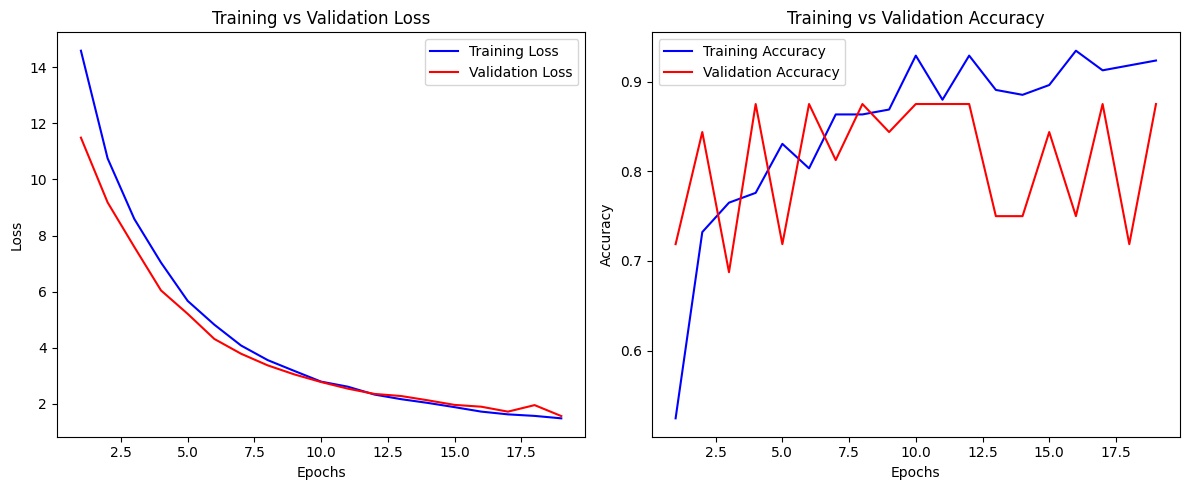

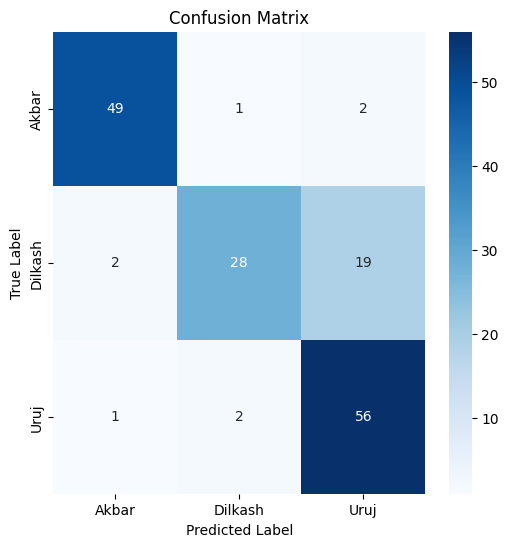

In [62]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [63]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)


efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5116 - loss: 11.9442 - val_accuracy: 0.7500 - val_loss: 9.8831
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6704 - loss: 9.5802 - val_accuracy: 0.6875 - val_loss: 8.1821
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7313 - loss: 7.7248 - val_accuracy: 0.8438 - val_loss: 6.4595
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7955 - loss: 6.2617 - val_accuracy: 0.9062 - val_loss: 5.1879
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8750 - loss: 4.9895 - val_accuracy: 0.7188 - val_loss: 4.3695
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8183 - loss: 4.1697 - val_accuracy: 0.8750 - val_loss: 3.4621
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8576 - loss: 3.3829 - val_accuracy: 0.9062 - val_loss: 2.8929
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8274 - loss: 2.8463 - val_accuracy: 0.9062 - val_loss: 2.4581


Accuracy:  0.8313
Precision: 0.8510
Recall:    0.8313
F1-Score:  0.8243

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.94      0.94      0.94        52
     Dilkash       0.90      0.57      0.70        49
        Uruj       0.73      0.95      0.82        59

    accuracy                           0.83       160
   macro avg       0.86      0.82      0.82       160
weighted avg       0.85      0.83      0.82       160



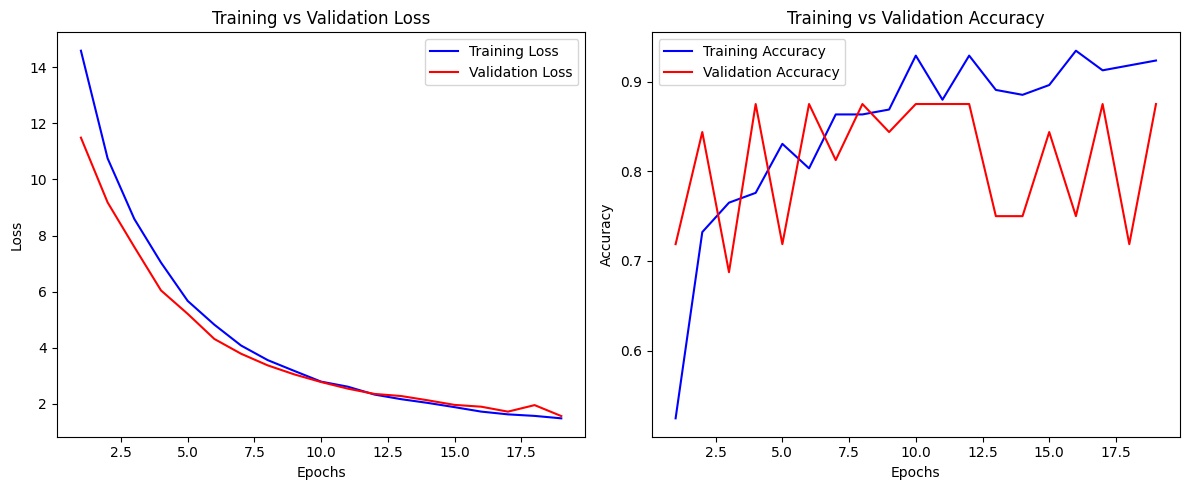

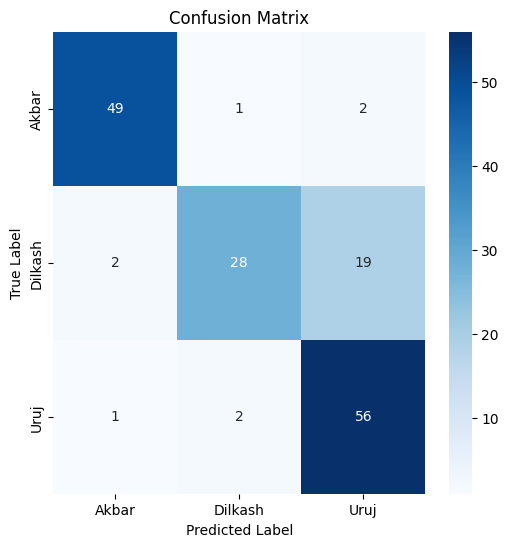

In [64]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [65]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 760ms/step - accuracy: 0.5137 - loss: 10.7863 - val_accuracy: 0.7188 - val_loss: 8.5354
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6401 - loss: 8.3505 - val_accuracy: 0.7812 - val_loss: 6.8213
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6639 - loss: 6.6557 - val_accuracy: 0.7500 - val_loss: 5.2736
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7342 - loss: 5.1745 - val_accuracy: 0.7812 - val_loss: 4.2089
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7375 - loss: 4.2076 - val_accuracy: 0.7812 - val_loss: 3.4203
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8069 - loss: 3.3123 - val_accuracy: 0.8125 - val_loss: 2.9093
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8083 - loss: 2.8094 - val_accuracy: 0.8125 - val_loss: 2.5015
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7752 - loss: 2.4956 - val_accuracy: 0.7500 - val_loss: 2.20

Accuracy:  0.8438
Precision: 0.8479
Recall:    0.8438
F1-Score:  0.8411

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.98      0.98      0.98        52
     Dilkash       0.82      0.65      0.73        49
        Uruj       0.75      0.88      0.81        59

    accuracy                           0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160



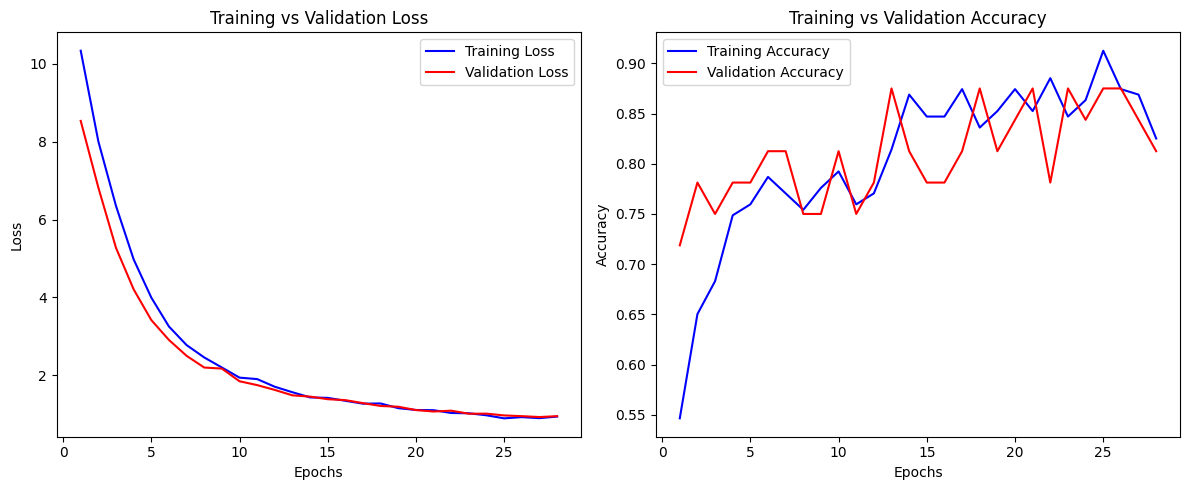

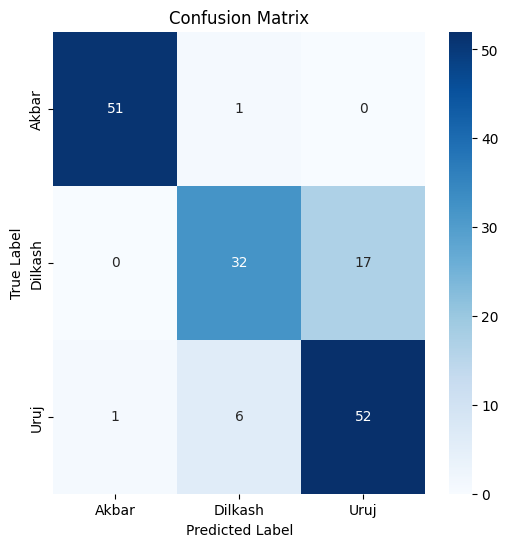

In [66]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [67]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.6
val_split = 0.1
test_split = 0.3

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")




Total images: 375
Train: 225, Val: 37, Test: 113


In [68]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)


Epoch [1/50] Train Loss: 1.0996 Train Acc: 0.4267 Val Loss: 1.0279 Val Acc: 0.5676
Epoch [2/50] Train Loss: 0.9599 Train Acc: 0.6000 Val Loss: 0.9616 Val Acc: 0.6486
Epoch [3/50] Train Loss: 0.9446 Train Acc: 0.6756 Val Loss: 0.8705 Val Acc: 0.5676
Epoch [4/50] Train Loss: 0.9461 Train Acc: 0.6400 Val Loss: 0.8214 Val Acc: 0.6757
Epoch [5/50] Train Loss: 0.8066 Train Acc: 0.6756 Val Loss: 0.7546 Val Acc: 0.7027
Epoch [6/50] Train Loss: 0.8429 Train Acc: 0.6978 Val Loss: 0.7113 Val Acc: 0.6486
Epoch [7/50] Train Loss: 0.8230 Train Acc: 0.7156 Val Loss: 0.7036 Val Acc: 0.6216
Epoch [8/50] Train Loss: 0.8430 Train Acc: 0.7333 Val Loss: 0.6611 Val Acc: 0.6216
Epoch [9/50] Train Loss: 0.7246 Train Acc: 0.7200 Val Loss: 0.6326 Val Acc: 0.6216
Epoch [10/50] Train Loss: 0.7722 Train Acc: 0.7244 Val Loss: 0.6190 Val Acc: 0.6216
Epoch [11/50] Train Loss: 0.6741 Train Acc: 0.8044 Val Loss: 0.6254 Val Acc: 0.7027
Epoch [12/50] Train Loss: 0.7210 Train Acc: 0.7822 Val Loss: 0.5924 Val Acc: 0.7027
E

Accuracy:  0.8761
Precision: 0.8790
Recall:    0.8761
F1-Score:  0.8772

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.97      0.92      0.94        36
     Dilkash       0.73      0.76      0.75        25
        Uruj       0.89      0.90      0.90        52

    accuracy                           0.88       113
   macro avg       0.86      0.86      0.86       113
weighted avg       0.88      0.88      0.88       113



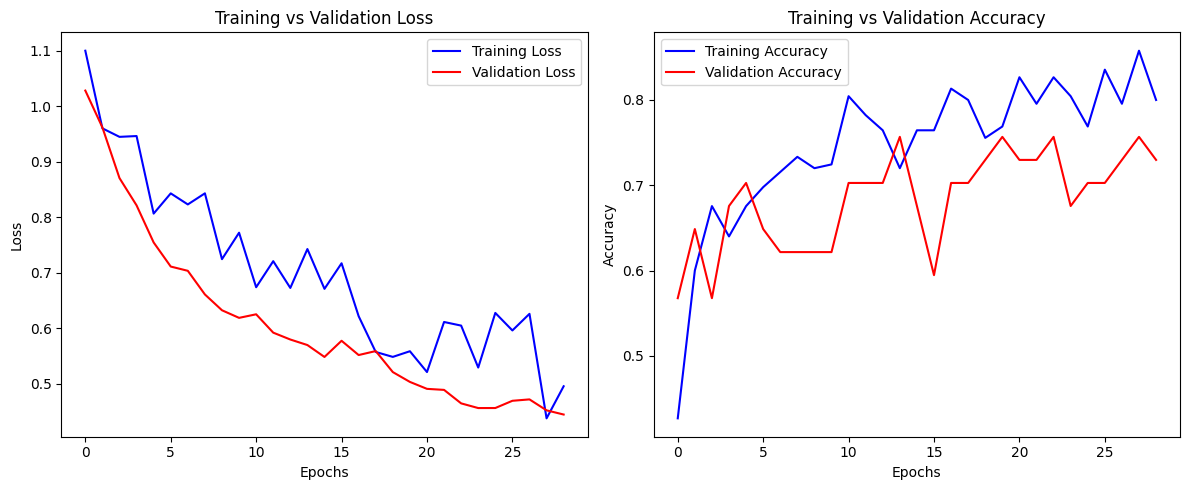

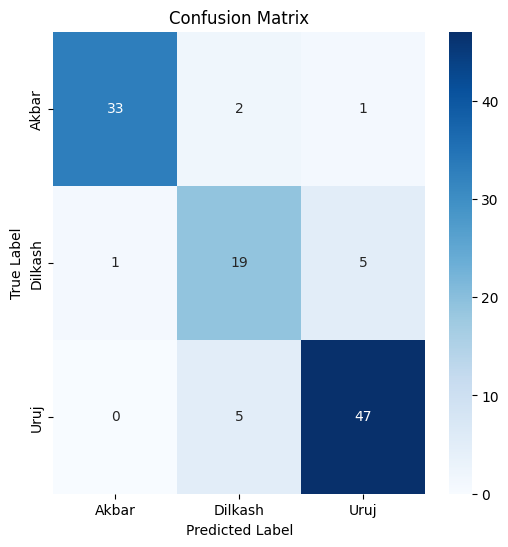

In [69]:
googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

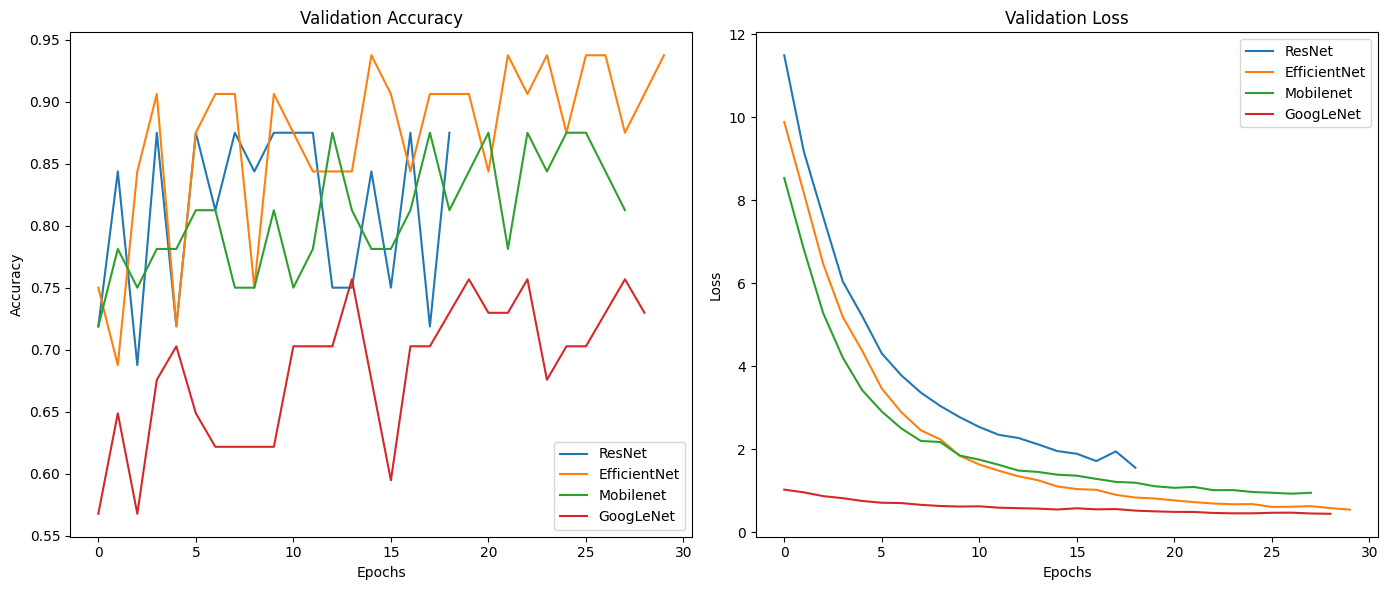

<Figure size 1400x600 with 0 Axes>

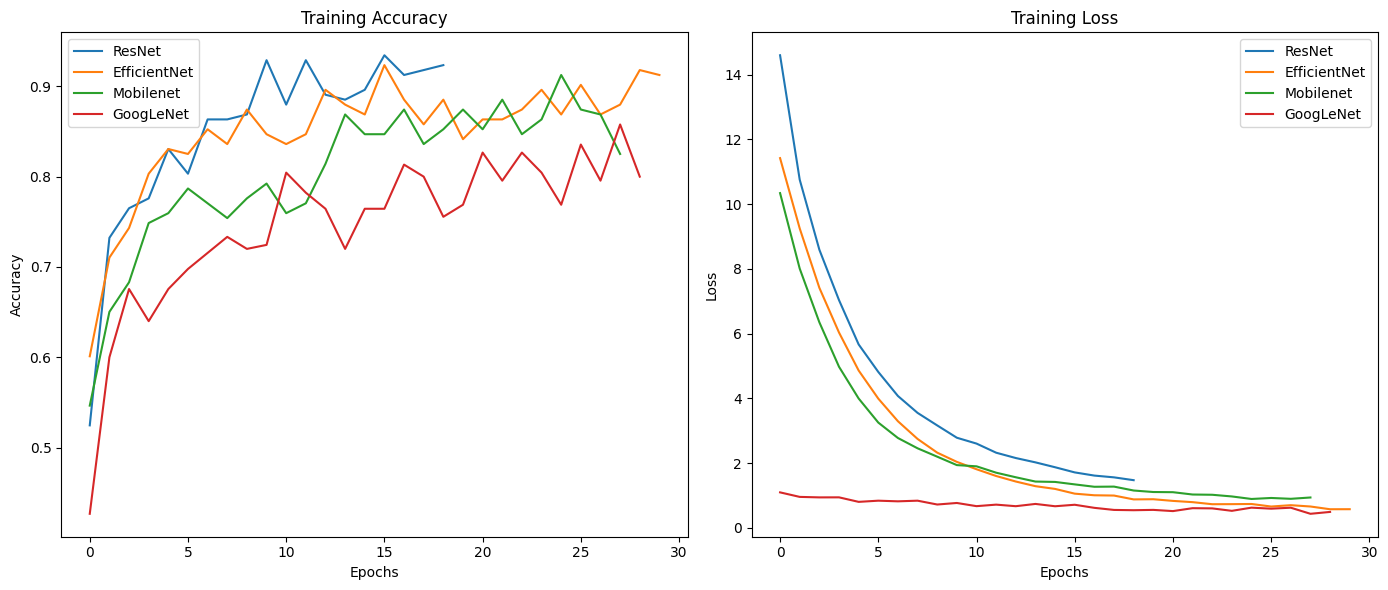

In [71]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
